In [ ]:
#Esta es una nueva versión en la que quiero dar más énfasis a los enlaces reales que hay en el dataset 
#para así garantixar la fidelidad. Cambiando sobre todo la generación de negativos,añadir pos_weight y ajustar 
#hiperparámetros de entrenamiento.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
import networkx as nx
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
import time
import matplotlib.pyplot as plt
import random
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit
from torch import Tensor
from sklearn.metrics import roc_auc_score, accuracy_score
import tqdm
import os
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

## Crear nuestro Grafo

In [2]:
def create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path, verbose=True):
    """
    Crea un grafo heterogéneo a partir de:
      - Un CSV de nodos que contiene columnas como "primaryDomainId", "type", "name", "description", etc.
      - Un CSV de edges que contiene, entre otros, las columnas "sourceDomainId", "targetDomainId" y una columna "relation"
        que puede tener valores como "DrugHasIndication", "DrugHasTarget", "ProteinEncodedByGene", "DisorderIsSubtypeOfDisorder", etc.
      - Un fichero .pkl con embeddings ya generados (por ejemplo, a partir de BERT) para cada nodo, mapeados mediante "primaryDomainId".
    
    El grafo resultante tendrá nodos agrupados por tipo (ej. "Drug", "Disorder", "Gene", "Protein") y edges etiquetados según la relación.
    Para nuestro objetivo, las relaciones de interés son las de tipo ("Drug", "DrugHasIndication", "Disorder").
    """
    data = HeteroData()
    
    # Cargar embeddings (suponemos que el .pkl tiene un diccionario con claves "Nodes Name" y "New Embedding")
    if verbose:
        print(f"[INFO] Cargando embeddings desde '{embeddings_pkl_path}'...")
    with open(embeddings_pkl_path, 'rb') as f:
        embeddings_dict = pickle.load(f)
    node_ids = embeddings_dict.get('Nodes Name', [])
    node_embeddings = embeddings_dict.get('New Embedding', [])
    embedding_map = {str(nid): np.array(emb) for nid, emb in zip(node_ids, node_embeddings)}
    
    # Cargar el CSV de nodos
    if verbose:
        print(f"[INFO] Cargando nodos desde '{nodes_csv_path}'...")
    nodes_df = pd.read_csv(nodes_csv_path, low_memory=False)
    
    # Crear un mapeo de nodo_id a tipo (usando la columna "type")
    id_to_type = {}
    # Inicializamos contenedores para cada tipo de nodo
    for ntype in ["Drug", "Disorder", "Gene", "Protein"]:
        data[ntype].x = []  # lista para acumular features
        data[ntype].id = []  # para almacenar el identificador original
    
    # Procesar cada nodo
    for _, row in nodes_df.iterrows():
        node_id = str(row['primaryDomainId'])
        node_type = row['type']
        # Solo procesamos los tipos de interés
        if node_type not in data.node_types:
            continue
        id_to_type[node_id] = node_type
        # Obtener la feature: si existe embedding para el nodo, lo usamos; si no, generamos un vector de ceros.
        if node_id in embedding_map:
            feat = embedding_map[node_id]
        else:
            # Supongamos dimensión 128 (ajusta según tu caso)
            feat = np.zeros(128)
        data[node_type].x.append(feat)
        data[node_type].id.append(node_id)
    
    # Convertir las listas de features a tensores para cada tipo de nodo
    for ntype in data.node_types:
        if len(data[ntype].x) > 0:
            features_array = np.array(data[ntype].x)
            data[ntype].x = torch.from_numpy(features_array).float()
            if hasattr(data[ntype], 'y') and isinstance(data[ntype].y, list):
                labels_array = np.array(data[ntype].y)
                data[ntype].y = torch.from_numpy(labels_array).long()
            if verbose:
                print(f"[INFO] {data[ntype].x.size(0)} nodos de tipo '{ntype}' con features de dimensión {data[ntype].x.size(1)}.")
        else:
            if verbose:
                print(f"[WARN] No se encontraron nodos de tipo '{ntype}'.")

    # Cargar el CSV de edges
    if verbose:
        print(f"[INFO] Cargando edges desde '{edges_csv_path}'...")
    edges_df = pd.read_csv(edges_csv_path, low_memory=False)
    
    # Procesar cada edge y agruparlos por tipo de relación
    # Se asume que el CSV de edges tiene columnas: "sourceDomainId", "targetDomainId" y "relation"
    edge_dict = {}  # clave: (src_type, relation, tgt_type) -> [lista de índices de origen, lista de índices de destino]
    for _, row in edges_df.iterrows():
        src_id = str(row['sourceDomainId'])
        tgt_id = str(row['targetDomainId'])
        relation = row['type']  # Ejemplos: "DrugHasIndication", "DrugHasTarget", etc.
        # Obtener tipos de nodo para el source y target
        src_type = id_to_type.get(src_id, None)
        tgt_type = id_to_type.get(tgt_id, None)
        if src_type is None or tgt_type is None:
            continue
        key = (src_type, relation, tgt_type)
        if key not in edge_dict:
            edge_dict[key] = [[], []]
        # Buscar el índice interno del nodo en su grupo
        try:
            src_idx = data[src_type].id.index(src_id)
            tgt_idx = data[tgt_type].id.index(tgt_id)
        except ValueError:
            continue
        edge_dict[key][0].append(src_idx)
        edge_dict[key][1].append(tgt_idx)
    
    # Agregar los edges al objeto HeteroData
    for (src_type, relation, tgt_type), (src_indices, tgt_indices) in edge_dict.items():
        edge_index = torch.tensor([src_indices, tgt_indices], dtype=torch.long)
        data[(src_type, relation, tgt_type)].edge_index = edge_index
        if verbose:
            print(f"[INFO] Agregados {edge_index.size(1)} edges para la relación ({src_type}, '{relation}', {tgt_type}).")
            
    #Añadir aristas inversas (reverse edges) para mejorar la propagación de información entre nodos y estabiliza el entrenamiento.        
    data = ToUndirected()(data)
    return data

#### Comprobaciones de que el grafo está bien hecho

In [3]:
def plot_graph_sample(data, max_nodes=100):
    """
    Visualiza un subgrafo del grafo heterogéneo, limitando la cantidad de nodos y edges para hacerlo legible.
    """
    G = nx.Graph()

    # Agregar nodos
    for node_type in data.node_types:
        num_nodes = data[node_type].x.shape[0]
        for i in range(min(num_nodes, max_nodes)):  # Limitar el número de nodos a mostrar
            G.add_node(f"{node_type}_{i}", label=node_type)

    # Agregar edges
    edge_colors = {}
    color_palette = ["r", "b", "g", "c", "m", "y"]
    
    for idx, edge_type in enumerate(data.edge_types):
        edge_index = data[edge_type].edge_index
        src_type, relation, tgt_type = edge_type
        color = color_palette[idx % len(color_palette)]  # Asignar un color diferente para cada tipo de relación
        edge_colors[relation] = color
        
        for i in range(min(edge_index.shape[1], max_nodes)):  # Limitar los edges a mostrar
            src = f"{src_type}_{edge_index[0, i].item()}"
            tgt = f"{tgt_type}_{edge_index[1, i].item()}"
            if src in G.nodes and tgt in G.nodes:
                G.add_edge(src, tgt, color=color)

    # Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout para organizar los nodos
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]

    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
    plt.title("Visualización de un Subgrafo del Grafo de Drogas y Enfermedades")
    plt.show()


Creando el grafo...
[INFO] Cargando embeddings desde 'embeddings_mejorados_biobert.pkl'...
[INFO] Cargando nodos desde 'nodes.csv'...
[INFO] 7167 nodos de tipo 'Drug' con features de dimensión 768.
[INFO] 26015 nodos de tipo 'Disorder' con features de dimensión 768.
[INFO] 19394 nodos de tipo 'Gene' con features de dimensión 768.
[INFO] 30501 nodos de tipo 'Protein' con features de dimensión 768.
[INFO] Cargando edges desde 'edges.csv'...
[INFO] Agregados 48497 edges para la relación (Gene, 'GeneAssociatedWithDisorder', Disorder).
[INFO] Agregados 38881 edges para la relación (Disorder, 'DisorderIsSubtypeOfDisorder', Disorder).
[INFO] Agregados 30432 edges para la relación (Protein, 'ProteinEncodedByGene', Gene).
[INFO] Agregados 30088 edges para la relación (Drug, 'DrugHasTarget', Protein).
[INFO] Agregados 17728 edges para la relación (Drug, 'DrugHasIndication', Disorder).

 Resumen del grafo creado:
  - Drug: 7167 nodos
  - Disorder: 26015 nodos
  - Gene: 19394 nodos
  - Protein: 30

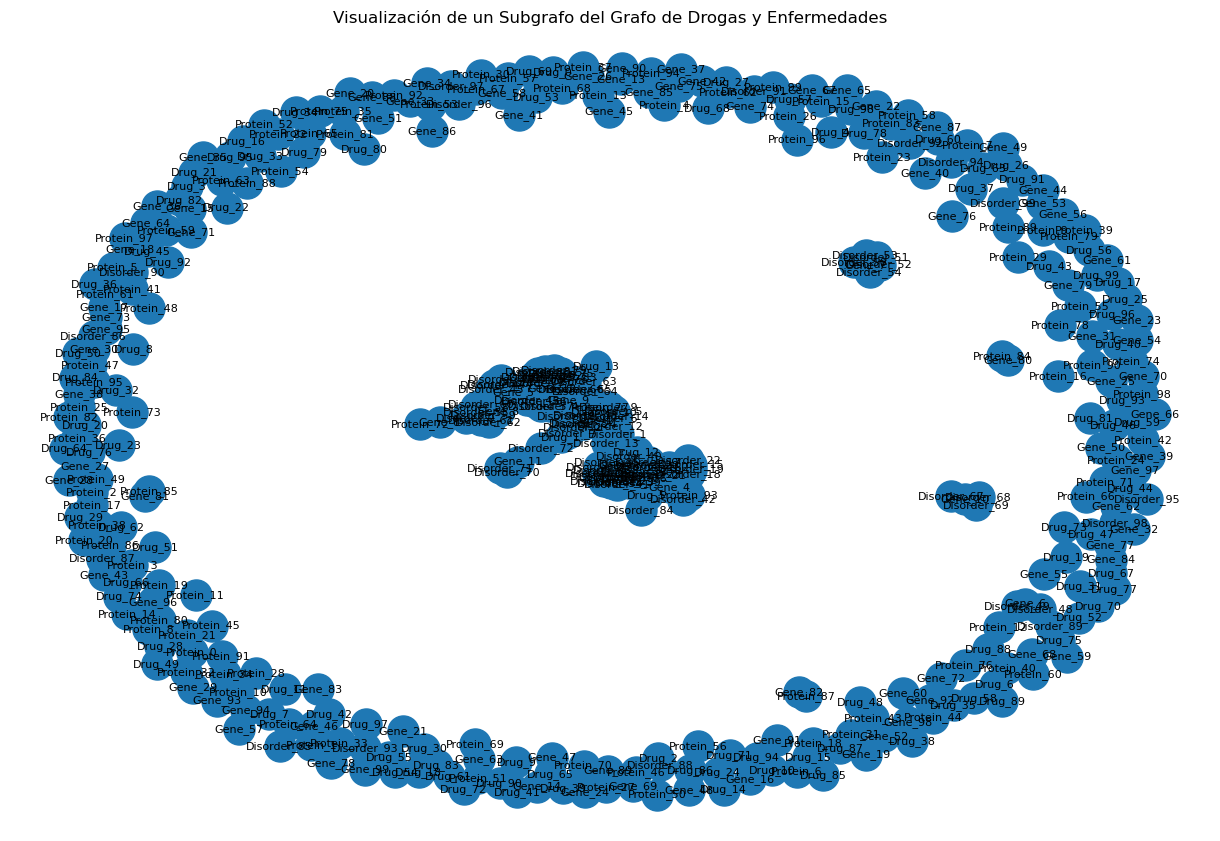

In [4]:
# Rutas a los archivos CSV y PKL
nodes_csv_path = "nodes.csv"
edges_csv_path = "edges.csv"
embeddings_pkl_path = "embeddings_mejorados_biobert.pkl"

# Crear el grafo
print("Creando el grafo...")
data = create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path)

# Revisar nodos y edges
print("\n Resumen del grafo creado:")
for node_type in data.node_types:
    num_nodes = data[node_type].x.shape[0] if hasattr(data[node_type], "x") else 0
    print(f"  - {node_type}: {num_nodes} nodos")

for edge_type in data.edge_types:
    num_edges = data[edge_type].edge_index.shape[1]
    print(f"  - {edge_type}: {num_edges} edges")

# Visualizar el grafo
print("\n Generando visualización del grafo...")
plot_graph_sample(data)


In [5]:
#Como el anterior grafo no se ve bien, mejor probar con uno más pequeño
def plot_disorder_subgraph(data, disorder_index=None, max_connections=10):
    """
    Dibuja un subgrafo con un solo nodo 'Disorder' y sus conexiones con 'Drug' y otros nodos relacionados.
    
    Parámetros:
    - data: Grafo heterogéneo PyG.
    - disorder_index: Índice del disorder a visualizar (si es None, elige uno aleatorio).
    - max_connections: Máximo número de conexiones a mostrar.
    """
    G = nx.Graph()

    # Obtener lista de desórdenes
    disorder_nodes = data['Disorder'].id if hasattr(data['Disorder'], 'id') else []
    if not disorder_nodes:
        print(" No se encontraron nodos de tipo 'Disorder'.")
        return
    
    # Seleccionar un disorder aleatorio si no se especifica
    if disorder_index is None:
        disorder_index = random.choice(range(len(disorder_nodes)))
    
    disorder_node = f"Disorder_{disorder_index}"
    G.add_node(disorder_node, label="Disorder", color="red")

    # Buscar conexiones con otras entidades
    edge_types = [("Drug", "DrugHasIndication"), ("Gene", "GeneAssociatedWithDisorder")]
    
    connections = 0
    for target_type, relation in edge_types:
        if (target_type, relation, "Disorder") in data.edge_types:
            edge_index = data[(target_type, relation, "Disorder")].edge_index
            for i in range(edge_index.shape[1]):
                if edge_index[1, i].item() == disorder_index:
                    target_idx = edge_index[0, i].item()
                    target_node = f"{target_type}_{target_idx}"
                    G.add_node(target_node, label=target_type, color="blue" if target_type == "Drug" else "green")
                    G.add_edge(disorder_node, target_node, relation=relation)
                    connections += 1
                    if connections >= max_connections:
                        break
    
    if G.number_of_edges() == 0:
        print(f" El nodo 'Disorder_{disorder_index}' no tiene conexiones relevantes.")
        return

    # Dibujar el grafo
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  
    colors = [G.nodes[n]["color"] for n in G.nodes]
    
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=8, edge_color="gray")
    plt.title(f"Subgrafo de 'Disorder_{disorder_index}' y sus conexiones")
    plt.show()


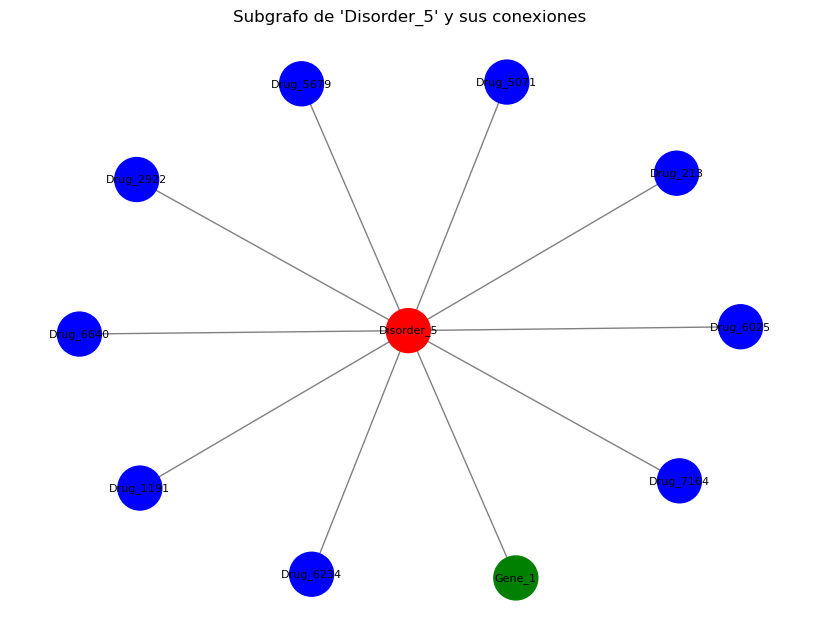

In [6]:
plot_disorder_subgraph(data, disorder_index=5)  # Si se quiere otra disorder se cambia el número


In [7]:
print(data)

HeteroData(
  Drug={
    x=[7167, 768],
    id=[7167],
  },
  Disorder={
    x=[26015, 768],
    id=[26015],
  },
  Gene={
    x=[19394, 768],
    id=[19394],
  },
  Protein={
    x=[30501, 768],
    id=[30501],
  },
  (Gene, GeneAssociatedWithDisorder, Disorder)={ edge_index=[2, 48497] },
  (Disorder, DisorderIsSubtypeOfDisorder, Disorder)={ edge_index=[2, 77762] },
  (Protein, ProteinEncodedByGene, Gene)={ edge_index=[2, 30432] },
  (Drug, DrugHasTarget, Protein)={ edge_index=[2, 30088] },
  (Drug, DrugHasIndication, Disorder)={ edge_index=[2, 17728] },
  (Disorder, rev_GeneAssociatedWithDisorder, Gene)={ edge_index=[2, 48497] },
  (Gene, rev_ProteinEncodedByGene, Protein)={ edge_index=[2, 30432] },
  (Protein, rev_DrugHasTarget, Drug)={ edge_index=[2, 30088] },
  (Disorder, rev_DrugHasIndication, Drug)={ edge_index=[2, 17728] }
)


In [8]:
def check_sizes(data, rel_key):
    if rel_key not in data.edge_types:
        print(f"Relación {rel_key} no está en data")
        return
    ei = data[rel_key].edge_index
    el = getattr(data[rel_key], 'edge_label', None)
    if el is None:
        print(f"edge_label no está definido para {rel_key}")
        return

    num_ei = ei.size(1)
    num_el = el.size(0)
    print(f"Check sizes -> edge_index: {num_ei}, edge_label: {num_el}")
    assert num_ei == num_el, f"Mismatch: edge_index={num_ei}, edge_label={num_el}"


## Pasos previos a entrenar el modelo 

### Dividir nuestro Heterodata para separarlo en train, val y test

In [11]:
# ------------------------------------------------------------------------------
# Función para dividir las aristas de un edge type en splits de train/val/test
# ------------------------------------------------------------------------------
def split_edge_indices(
    data: HeteroData,
    target_edge_type: tuple,
    train_ratio=0.7,
    val_ratio=0.1,
    test_ratio=0.2,
    seed=42
):
    """
    Divide las aristas de 'target_edge_type' en tres splits: train, val y test.
    Retorna tres objetos (train_data, val_data, test_data).

    Ejemplo de uso:
      train_data, val_data, test_data = split_edge_indices(
          data, ("Drug", "DrugHasIndication", "Disorder"), 0.7, 0.1, 0.2
      )

    - Se clonará 'data' 3 veces.
    - Para la relación 'target_edge_type', se asignará un subconjunto de aristas en
      cada clon (train_data, val_data, test_data).
    - El resto de relaciones y nodos se mantendrán idénticos en cada clon.
    - No genera negativos, ni edge_label_index, ni edge_label. Simplemente particiona
      el 'edge_index' de la relación objetivo en 3 partes.
    """

    # 1) Verificar que los ratios sumen ~1
    if not abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-7:
        raise ValueError("train_ratio + val_ratio + test_ratio debe ser = 1")

    # 2) Fijar semilla para reproducibilidad
    torch.manual_seed(seed)

    # 3) Extraer el edge_index de la relación objetivo
    if target_edge_type not in data.edge_types:
        raise ValueError(f"La relación {target_edge_type} no existe en data.edge_types.")

    edge_index = data[target_edge_type].edge_index  # [2, num_edges]
    num_edges = edge_index.size(1)

    # 4) Crear un permutado y dividir en train/val/test
    perm = torch.randperm(num_edges)
    train_end = int(train_ratio * num_edges)
    val_end = train_end + int(val_ratio * num_edges)

    train_indices = perm[:train_end]
    val_indices = perm[train_end:val_end]
    test_indices = perm[val_end:]

    # 5) Clonar el HeteroData original 3 veces
    train_data = copy.deepcopy(data)
    val_data = copy.deepcopy(data)
    test_data = copy.deepcopy(data)

    # 6) Asignar el subset de aristas a cada clon
    train_data[target_edge_type].edge_index = edge_index[:, train_indices]
    val_data[target_edge_type].edge_index = edge_index[:, val_indices]
    test_data[target_edge_type].edge_index = edge_index[:, test_indices]

    # (Opcional) Puedes imprimir las cantidades de edges en cada split
    print(f"Total edges for {target_edge_type}: {num_edges}")
    print(f"Train edges: {train_indices.numel()} | Val edges: {val_indices.numel()} | Test edges: {test_indices.numel()}")

    return train_data, val_data, test_data


In [17]:
def split_edge_indices(
    data,
    target_edge_type=("Drug","DrugHasIndication","Disorder"),
    train_ratio=0.7,
    val_ratio=0.1,
    test_ratio=0.2,
    seed=42
):
    import copy
    import torch

    total_ratio = train_ratio + val_ratio + test_ratio
    if not abs(total_ratio - 1.0) < 1e-7:
        raise ValueError("train_ratio + val_ratio + test_ratio debe ser = 1")

    torch.manual_seed(seed)

    # Extraer edge_index y edge_label
    edge_index = data[target_edge_type].edge_index  # [2, num_edges]
    edge_label = data[target_edge_type].edge_label  # [num_edges]
    num_edges = edge_index.size(1)
    if edge_label.size(0) != num_edges:
        raise RuntimeError(f"Desajuste: edge_index={num_edges}, edge_label={edge_label.size(0)}")

    perm = torch.randperm(num_edges)
    train_end = int(train_ratio * num_edges)
    val_end = train_end + int(val_ratio * num_edges)

    train_indices = perm[:train_end]
    val_indices   = perm[train_end:val_end]
    test_indices  = perm[val_end:]

    # Clonar
    import copy
    train_data = copy.deepcopy(data)
    val_data   = copy.deepcopy(data)
    test_data  = copy.deepcopy(data)

    train_data[target_edge_type].edge_index = edge_index[:, train_indices]
    val_data[target_edge_type].edge_index   = edge_index[:, val_indices]
    test_data[target_edge_type].edge_index  = edge_index[:, test_indices]

    train_data[target_edge_type].edge_label = edge_label[train_indices]
    val_data[target_edge_type].edge_label   = edge_label[val_indices]
    test_data[target_edge_type].edge_label  = edge_label[test_indices]

    print(f"Total edges: {num_edges}")
    print(f"Train: {train_indices.numel()} | Val: {val_indices.numel()} | Test: {test_indices.numel()}")
    return train_data, val_data, test_data


In [18]:
#Busca reforzar la fidelidad a los enlaces confirmados, evitando (en la medida de lo posible) 
#generar pares negativos que ya existen en el dataset y permitiendo reducir la cantidad de negativos. 
#Esto hará que el modelo no se confunda tanto con negativos duplicados y vea relativamente más positivos.

def add_negatives_for_link_pred(
    data,
    target_edge_type=("Drug","DrugHasIndication","Disorder"),
    neg_sampling_ratio=0.5,
    filter_existing=True,
    max_tries=10_000_000
):
    """
    Genera edge_label_index y edge_label (positivos + negativos) para la relación 'target_edge_type'.
    - 'neg_sampling_ratio': cuántos negativos (en proporción a #positivos) quieres.
    - 'filter_existing': si True, intenta no generar pares (drug,disorder) que ya existen como positivos.
    - 'max_tries': número máximo de intentos de muestreo aleatorio para evitar loop infinito en dataset muy grande.

    Recomendaciones:
    - Usar un 'neg_sampling_ratio' menor que 1.0 si quieres enfatizar la fidelidad a los enlaces confirmados.
    - 'filter_existing=True' asegura que no se generen falsos "negativos" que son en realidad positivos en el dataset.

    Retorna el 'data' con:
       data[target_edge_type].edge_label_index = [2, num_pos + num_neg]
       data[target_edge_type].edge_label       = [num_pos + num_neg]
    """

    import torch
    from torch.utils.data import Dataset

    rel = target_edge_type
    if rel not in data.edge_types:
        raise ValueError(f"La relación {rel} no existe en data.edge_types.")

    edge_index = data[rel].edge_index  # [2, num_pos_edges]
    row_pos = edge_index[0]
    col_pos = edge_index[1]
    num_pos = edge_index.size(1)

    # 1) Generar un conjunto de aristas positivas existentes si 'filter_existing' es True
    pos_set = set()
    if filter_existing:
        # Convertimos cada par (row, col) a tupla (r, c)
        # Ojo con performance en grafos muy grandes
        for r, c in zip(row_pos.tolist(), col_pos.tolist()):
            pos_set.add((r, c))

    # 2) Calcular cuántos negativos se desean
    num_neg = int(num_pos * neg_sampling_ratio)
    drug_nodes = data["Drug"].num_nodes
    disorder_nodes = data["Disorder"].num_nodes

    # 3) Generar pares negativos aleatorios
    neg_rows = []
    neg_cols = []

    tries = 0
    while len(neg_rows) < num_neg and tries < max_tries:
        tries += 1
        # Muestreamos un drug y un disorder aleatorio
        r = torch.randint(0, drug_nodes, (1,)).item()
        c = torch.randint(0, disorder_nodes, (1,)).item()

        if filter_existing:
            # Si ya existe como positivo, descartamos
            if (r, c) in pos_set:
                continue

        # Añadimos a la lista de negativos
        neg_rows.append(r)
        neg_cols.append(c)

    # En caso de no llegar a num_neg, avisamos
    if len(neg_rows) < num_neg:
        print(f"[!] Solo se generaron {len(neg_rows)} negativos en vez de {num_neg} "
              f"tras {tries} intentos. El dataset puede estar muy denso o 'neg_sampling_ratio' es alto.")

    neg_rows = torch.tensor(neg_rows, dtype=torch.long)
    neg_cols = torch.tensor(neg_cols, dtype=torch.long)

    # 4) Combinar positivos + negativos
    edge_label_index = torch.cat([
        edge_index, 
        torch.stack([neg_rows, neg_cols], dim=0)
    ], dim=1)  # [2, num_pos + num_neg]

    edge_label = torch.cat([
        torch.ones(num_pos),
        torch.zeros(len(neg_rows))
    ], dim=0)  # [num_pos + num_neg]

    # 5) Asignar a data
    data[rel].edge_label_index = edge_label_index
    data[rel].edge_label = edge_label

    print(f"Generados {num_pos} positivos y {len(neg_rows)} negativos en {rel} (ratio solicitado={neg_sampling_ratio}).")
    return data



In [14]:
import torch

def add_negatives_for_link_pred_vectorized(
    data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    neg_sampling_ratio=0.5,
    filter_existing=True
):
    """
    Genera edge_label_index y edge_label (positivos + negativos) para la relación 'target_edge_type'
    utilizando un muestreo vectorizado.

    Parámetros:
    -----------
    data: Objeto HeteroData.
    target_edge_type: tuple, la relación objetivo.
    neg_sampling_ratio: float, proporción de negativos respecto a positivos.
    filter_existing: bool, si True, no genera negativos que ya existan como positivos.
    
    Retorna:
    --------
    data: El objeto HeteroData modificado con edge_label_index y edge_label.
    """
    rel = target_edge_type
    if rel not in data.edge_types:
        raise ValueError(f"La relación {rel} no existe en data.edge_types.")
    
    edge_index = data[rel].edge_index  # [2, num_pos_edges]
    num_pos = edge_index.size(1)
    num_neg = int(num_pos * neg_sampling_ratio)

    drug_nodes = data["Drug"].num_nodes
    disorder_nodes = data["Disorder"].num_nodes

    # Crear conjunto de positivos para filtrar si es necesario
    pos_set = set()
    if filter_existing:
        for r, c in zip(edge_index[0].tolist(), edge_index[1].tolist()):
            pos_set.add((r, c))

    neg_rows = []
    neg_cols = []
    # Muestreo vectorizado: se generan muchos candidatos a la vez para aumentar la eficiencia.
    batch_size = num_neg * 2  # se generan el doble de candidatos de lo necesario
    while len(neg_rows) < num_neg:
        candidate_r = torch.randint(0, drug_nodes, (batch_size,)).tolist()
        candidate_c = torch.randint(0, disorder_nodes, (batch_size,)).tolist()
        for r, c in zip(candidate_r, candidate_c):
            if filter_existing and (r, c) in pos_set:
                continue
            neg_rows.append(r)
            neg_cols.append(c)
            if len(neg_rows) >= num_neg:
                break

    neg_rows = torch.tensor(neg_rows[:num_neg], dtype=torch.long)
    neg_cols = torch.tensor(neg_cols[:num_neg], dtype=torch.long)
    neg_edge_index = torch.stack([neg_rows, neg_cols], dim=0)

    # Combinar positivos y negativos
    combined_edge_index = torch.cat([edge_index, neg_edge_index], dim=1)
    combined_edge_label = torch.cat([torch.ones(num_pos), torch.zeros(num_neg)], dim=0)

    data[rel].edge_label_index = combined_edge_index
    data[rel].edge_label = combined_edge_label

    print(f"Generados {num_pos} positivos y {num_neg} negativos en {rel} (ratio solicitado = {neg_sampling_ratio}).")
    return data


In [15]:
train_data, val_data, test_data = split_edge_indices(
    data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    train_ratio=0.7,
    val_ratio=0.1,
    test_ratio=0.2,
    seed=42
    )

# Luego, generar negativos y edge_label en cada subset
# 1) Generar negativos en train_data con un ratio menor (por ejemplo, 0.2)
train_data = add_negatives_for_link_pred(
    train_data,
    target_edge_type=("Drug","DrugHasIndication","Disorder"),
    neg_sampling_ratio=0.2,       # Menos negativos en train
    filter_existing=True
)

# 2) Generar negativos en val_data con un ratio mayor (por ejemplo, 1.0)
val_data = add_negatives_for_link_pred(
    val_data,
    target_edge_type=("Drug","DrugHasIndication","Disorder"),
    neg_sampling_ratio=1.0,       # 1:1 en val
    filter_existing=True
)

# 3) Generar negativos en test_data con ratio 1.0 o el que prefieras
test_data = add_negatives_for_link_pred(
    test_data,
    target_edge_type=("Drug","DrugHasIndication","Disorder"),
    neg_sampling_ratio=1.0,       # 1:1 en test
    filter_existing=True
)


AttributeError: 'EdgeStorage' object has no attribute 'edge_label'

In [16]:
# Partición del grafo en train, val y test
train_data, val_data, test_data = split_edge_indices(
    data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    train_ratio=0.7,
    val_ratio=0.1,
    test_ratio=0.2,
    seed=42
)

# Generar negativos en cada split usando la función vectorizada:
# Para el entrenamiento, se suele usar un ratio menor, por ejemplo 0.2.
train_data = add_negatives_for_link_pred_vectorized(
    train_data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    neg_sampling_ratio=0.2,
    filter_existing=True
)

# Para validación y test se puede usar un ratio 1:1 (neg_sampling_ratio=1.0)
val_data = add_negatives_for_link_pred_vectorized(
    val_data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    neg_sampling_ratio=1.0,
    filter_existing=True
)

test_data = add_negatives_for_link_pred_vectorized(
    test_data,
    target_edge_type=("Drug", "DrugHasIndication", "Disorder"),
    neg_sampling_ratio=1.0,
    filter_existing=True
)


AttributeError: 'EdgeStorage' object has no attribute 'edge_label'

In [13]:
train_data.metadata()

(['Drug', 'Disorder', 'Gene', 'Protein'],
 [('Gene', 'GeneAssociatedWithDisorder', 'Disorder'),
  ('Disorder', 'DisorderIsSubtypeOfDisorder', 'Disorder'),
  ('Protein', 'ProteinEncodedByGene', 'Gene'),
  ('Drug', 'DrugHasTarget', 'Protein'),
  ('Drug', 'DrugHasIndication', 'Disorder'),
  ('Disorder', 'rev_GeneAssociatedWithDisorder', 'Gene'),
  ('Gene', 'rev_ProteinEncodedByGene', 'Protein'),
  ('Protein', 'rev_DrugHasTarget', 'Drug'),
  ('Disorder', 'rev_DrugHasIndication', 'Drug')])

In [14]:
train_data

HeteroData(
  Drug={
    x=[7167, 768],
    id=[7167],
  },
  Disorder={
    x=[26015, 768],
    id=[26015],
  },
  Gene={
    x=[19394, 768],
    id=[19394],
  },
  Protein={
    x=[30501, 768],
    id=[30501],
  },
  (Gene, GeneAssociatedWithDisorder, Disorder)={ edge_index=[2, 48497] },
  (Disorder, DisorderIsSubtypeOfDisorder, Disorder)={ edge_index=[2, 77762] },
  (Protein, ProteinEncodedByGene, Gene)={ edge_index=[2, 30432] },
  (Drug, DrugHasTarget, Protein)={ edge_index=[2, 30088] },
  (Drug, DrugHasIndication, Disorder)={
    edge_index=[2, 12409],
    edge_label_index=[2, 14890],
    edge_label=[14890],
  },
  (Disorder, rev_GeneAssociatedWithDisorder, Gene)={ edge_index=[2, 48497] },
  (Gene, rev_ProteinEncodedByGene, Protein)={ edge_index=[2, 30432] },
  (Protein, rev_DrugHasTarget, Drug)={ edge_index=[2, 30088] },
  (Disorder, rev_DrugHasIndication, Drug)={ edge_index=[2, 17728] }
)

## Creación de nuestro modelo GraphSAGE

In [2]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels,dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, 32)
        self.dropout = dropout  # Probabilidad de dropout
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # Primera capa
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Segunda capa
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Tercera capa (salida de 32)
        x = self.conv3(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_drug: Tensor, x_disorder: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_drug = x_drug[edge_label_index[0]]
        edge_feat_disorder = x_disorder[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_drug * edge_feat_disorder).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.3):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.disorder_lin = torch.nn.Linear(768, hidden_channels)
        self.drug_lin = torch.nn.Linear(768, hidden_channels)
        self.protein_lin = torch.nn.Linear(768, hidden_channels)
        self.gene_lin = torch.nn.Linear(768, hidden_channels)
        
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels, dropout=dropout)
        
        # Convert GNN model into a heterogeneous variant:
        # Convertir a heterogéneo usando la metadata de 'data':
        node_types, edge_types = data.metadata()
        self.gnn = to_hetero(self.gnn, (node_types, edge_types))
        self.classifier = Classifier()
        
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "Drug": self.drug_lin(data["Drug"].x),
          "Disorder": self.disorder_lin(data["Disorder"].x),
          "Protein": self.protein_lin(data["Protein"].x),
          "Gene": self.gene_lin(data["Gene"].x),

        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["Drug"],
            x_dict["Disorder"],
            data["Drug", "DrugHasIndication", "Disorder"].edge_label_index,
        )
        return pred

model = Model(hidden_channels=64, dropout=0.3)

print(model)

NameError: name 'data' is not defined

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.data import HeteroData

# GNN con capas extra, BatchNorm y dropout.
class GNN(nn.Module):
    def __init__(self, hidden_channels, dropout=0.3, num_layers=4):
        """
        Crea un GNN con 'num_layers' capas SAGEConv.
        Las capas intermedias (excepto la última) mantienen la dimensión 'hidden_channels'
        y aplican BatchNorm y activación ReLU. La última capa reduce la dimensión a 128. Luego lo hice sin reducir la ultima capa
        """
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # Primera capa: de hidden_channels a hidden_channels.
        self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.bns.append(nn.BatchNorm1d(hidden_channels))
        # Capas intermedias (num_layers - 2)
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.bns.append(nn.BatchNorm1d(hidden_channels))
        # Última capa: reduce a 128 dimensiones.
        self.convs.append(SAGEConv(hidden_channels, 768))
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Para las capas intermedias
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        # Última capa (salida lineal sin activación ni BN)
        x = self.convs[-1](x, edge_index)
        return x

# Clasificador basado en MLP que concatena las representaciones de drug y disorder.
class ClassifierMLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=768):
        """
        Recibe representaciones de dimensión 'in_channels' de cada nodo y
        utiliza un MLP para predecir la probabilidad de enlace.
        Cada nodo tiene representación de dimensión in_channels, por lo que al concatenar se obtiene 2*in_channels.
        Por ello, se define:
          - fc1: de 2*in_channels (256 si in_channels=128) a hidden_channels (128 en este ejemplo)
          - fc2: de hidden_channels a 1.
        """
        super().__init__()
        self.fc1 = nn.Linear(in_channels * 2, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)
    
    def forward(self, x_drug: torch.Tensor, x_disorder: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Extraer las representaciones para cada par
        edge_feat_drug = x_drug[edge_label_index[0]]
        edge_feat_disorder = x_disorder[edge_label_index[1]]
        # Concatenar las características (dimensión resultante: 2*in_channels, ej. 256)
        x = torch.cat([edge_feat_drug, edge_feat_disorder], dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)
        return x

# Modelo final que utiliza embeddings de entrada, un GNN heterogéneo y el clasificador MLP.
class Model(nn.Module):
    def __init__(self, hidden_channels, dropout=0.3):
        """
        Crea el modelo final:
          - Se aprende una transformación lineal de 768 a 'hidden_channels' para cada tipo de nodo.
          - Se utiliza un GNN con 3 capas (con BatchNorm y dropout) que reduce la dimensión a 128.
          - Se convierte el GNN a heterogéneo con to_hetero usando la metadata del grafo.
          - Se clasifica mediante un MLP que concatena las representaciones de fármaco y disorder.
        """
        super().__init__()
        # Transformaciones lineales para cada tipo de nodo (entrada: 768)
        self.disorder_lin = nn.Linear(768, hidden_channels)
        self.drug_lin = nn.Linear(768, hidden_channels)
        self.protein_lin = nn.Linear(768, hidden_channels)
        self.gene_lin = nn.Linear(768, hidden_channels)
        
        # Instanciar el GNN: se espera que la entrada tenga dimensión 'hidden_channels' (en este caso, 768)
        # y que la última capa reduzca la dimensión a 128.
        self.gnn = GNN(hidden_channels, dropout=dropout, num_layers=3)
        
        # Almacenaremos la versión heterogénea del GNN una vez convertida.
        self.hetero_gnn = None
        
        # Clasificador MLP: espera que la salida del GNN tenga 128 dimensiones para cada nodo.
        # Al concatenar las representaciones de Drug y Disorder se obtiene un vector de dimensión 256.
        # Por ello, se define in_channels=128 y hidden_channels del clasificador a 128 (puedes ajustar este valor).
        self.classifier = ClassifierMLP(in_channels=768, hidden_channels=768)
        
    def forward(self, data: HeteroData) -> torch.Tensor:
        # Aplicar las transformaciones lineales a las características de cada tipo.
        x_dict = {
            "Drug": self.drug_lin(data["Drug"].x),
            "Disorder": self.disorder_lin(data["Disorder"].x),
            "Protein": self.protein_lin(data["Protein"].x),
            "Gene": self.gene_lin(data["Gene"].x),
        }
        # Convertir el GNN a heterogéneo si aún no se ha hecho.
        if self.hetero_gnn is None:
            node_types, edge_types = data.metadata()
            self.hetero_gnn = to_hetero(self.gnn, (node_types, edge_types))
            self.hetero_gnn = self.hetero_gnn.to(data["Drug"].x.device)
        # Propagar los features por el GNN heterogéneo.
        x_dict = self.hetero_gnn(x_dict, data.edge_index_dict)
        
        # Usar el clasificador para la relación ("Drug", "DrugHasIndication", "Disorder").
        pred = self.classifier(
            x_dict["Drug"],
            x_dict["Disorder"],
            data["Drug", "DrugHasIndication", "Disorder"].edge_label_index,
        )
        return pred

# Instanciación del modelo.
# Si se desea mantener la dimensión de entrada, se puede pasar hidden_channels=768.
model = Model(hidden_channels=768, dropout=0.3)
print(model)


Model(
  (disorder_lin): Linear(in_features=768, out_features=768, bias=True)
  (drug_lin): Linear(in_features=768, out_features=768, bias=True)
  (protein_lin): Linear(in_features=768, out_features=768, bias=True)
  (gene_lin): Linear(in_features=768, out_features=768, bias=True)
  (gnn): GNN(
    (convs): ModuleList(
      (0-2): 3 x SAGEConv(768, 768, aggr=mean)
    )
    (bns): ModuleList(
      (0-1): 2 x BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (classifier): ClassifierMLP(
    (fc1): Linear(in_features=1536, out_features=768, bias=True)
    (fc2): Linear(in_features=768, out_features=1, bias=True)
  )
)


## Training

## Enfoque 1

In [33]:
#Penalizar falsos negativos usando pos_weight.
#Medir la fidelidad con recall@k -> La función calc_recall_topk (o recall@k) sirve para medir qué porcentaje 
#de los enlaces reales (positivos) aparecen dentro de los k enlaces con mayor probabilidad según tu modelo. 
#Es una forma de cuantificar la fidelidad del modelo a los enlaces confirmados, más allá de la AUC.

############################################
# Función auxiliar para calcular recall@k
############################################
def compute_recall_at_k(probs, labels, k=50):
    """
    Dado un vector de probabilidades 'probs' y un vector binario 'labels'
    (de igual longitud), calcula el recall@k:
      - Se ordenan las aristas descendentemente por 'probs'
      - Se toma el top-k
      - Se cuenta cuántos positivos (labels=1) hay en ese top-k
      - Se divide por el total de positivos en 'labels'
    """
    # Ordenar descendentemente
    sorted_indices = np.argsort(-probs)
    top_k_indices = sorted_indices[:k]

    # Conteo de positivos en top-k
    positives_in_topk = labels[top_k_indices].sum()  # cuántos 1 hay en ese subset
    total_positives = labels.sum() + 1e-8  # evitar div 0

    recall_at_k = positives_in_topk / total_positives
    return recall_at_k

############################################
# train_epoch
############################################
def train_epoch(model, data, optimizer, pos_weight=None, device='cpu', calc_recall_topk=None):
    """
    Ejecuta un epoch de entrenamiento (full-batch) en 'data'.
    Si 'pos_weight' se define, se usará en BCE para mitigar desbalance de clases.
    'calc_recall_topk': si no es None, calculará recall@k de los positivos.
    """
    model.train()
    data = data.to(device)  # Mover todo a GPU si disponible
    optimizer.zero_grad()

    # Forward
    pred = model(data)  # [num_edges_label]
    ground_truth = data["Drug", "DrugHasIndication", "Disorder"].edge_label  # [num_edges_label]

    if pos_weight is not None:
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth, pos_weight=pos_weight)
    else:
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Evitar gradientes explosivos
    optimizer.step()

    # Métricas
    probs = torch.sigmoid(pred).detach().cpu().numpy()
    labels = ground_truth.detach().cpu().numpy()
    auc = roc_auc_score(labels, probs)
    acc = accuracy_score(labels, (probs >= 0.5))

    # (MODIFICADO) Calcular recall@k si se desea
    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)

    # Retornamos recall_at_k como valor opcional
    return loss.item(), auc, acc, recall_at_k

############################################
# evaluate
############################################
@torch.no_grad()
def evaluate(model, data, pos_weight=None, device='cpu', calc_recall_topk=None):
    """
    Evalúa el modelo en 'data' (full-batch). 
    Calcula la misma pérdida, AUC y accuracy.
    'calc_recall_topk': si no es None, calculará recall@k de los positivos.
    """
    model.eval()
    data = data.to(device)

    pred = model(data)
    ground_truth = data["Drug", "DrugHasIndication", "Disorder"].edge_label

    if pos_weight is not None:
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth, pos_weight=pos_weight)
    else:
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

    probs = torch.sigmoid(pred).cpu().numpy()
    labels = ground_truth.cpu().numpy()
    auc = roc_auc_score(labels, probs)
    acc = accuracy_score(labels, (probs >= 0.5))

    # (MODIFICADO) Calcular recall@k si se desea
    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)

    return loss.item(), auc, acc, recall_at_k

############################################
# train_loop
############################################
def train_loop(model, train_data, val_data, epochs=200, lr=1e-5, weight_decay=1e-4, 
               model_file="gnn_model.pth", device='cpu',
               calc_recall_topk=None):
    """
    Bucle principal de entrenamiento con:
      - AdamW (lr, weight_decay).
      - Scheduler ReduceLROnPlateau que reduce LR si no mejora la val_auc.
      - Early stopping con paciencia=10.
      - Guardado del mejor modelo según val_auc.
    (MODIFICADO) 'calc_recall_topk': para calcular recall@k en train y val.
    """
    model = model.to(device)  # Mover el modelo a GPU/CPU
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler que reduce LR a la mitad si val_auc no mejora tras 3 epochs
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    best_val_auc = 0.0
    patience = 10
    early_stop_counter = 0

    ############################################################
    # (MODIFICADO) Calcular pos_weight si hay desbalance de clases en train_data
    # Activar esto si quieres forzar su uso
    pos_count = (train_data["Drug", "DrugHasIndication", "Disorder"].edge_label == 1).sum().item()
    neg_count = (train_data["Drug", "DrugHasIndication", "Disorder"].edge_label == 0).sum().item()
    if pos_count > 0:
        pos_weight_value = neg_count / (pos_count + 1e-8)
        pos_weight = torch.tensor([pos_weight_value], device=device)
        print(f"[INFO] pos_weight={pos_weight.item():.4f} (neg_count={neg_count}, pos_count={pos_count})")
    else:
        pos_weight = None
    ############################################################

    for epoch in range(1, epochs+1):
        # Entrenamiento (calc_recall_topk si quieres ver la fidelidad en train)
        train_loss, train_auc, train_acc, train_recall = train_epoch(
            model, train_data, optimizer, pos_weight, device, calc_recall_topk
        )

        # Evaluación en validación
        val_loss, val_auc, val_acc, val_recall = evaluate(
            model, val_data, pos_weight, device, calc_recall_topk
        )

        # Reducir LR si no mejora val_auc
        scheduler.step(val_auc)

        # (MODIFICADO) Imprimimos recall@k si se calculó
        if calc_recall_topk is not None:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {train_loss:.4f} | AUC: {train_auc:.4f} | Acc: {train_acc:.4f} | Recall@{calc_recall_topk}={train_recall:.4f} || "
                  f"Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | Acc: {val_acc:.4f} | Recall@{calc_recall_topk}={val_recall:.4f} "
                  f"| LR: {optimizer.param_groups[0]['lr']:.2e}")
        else:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {train_loss:.4f} | AUC: {train_auc:.4f} | Acc: {train_acc:.4f} || "
                  f"Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | Acc: {val_acc:.4f} "
                  f"| LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping y guardado del mejor modelo
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), model_file)
            print(f"  [*] Model saved at epoch {epoch} (val_auc={best_val_auc:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"  [!] Early stopping triggered at epoch {epoch}")
                break

    # Cargar el mejor modelo
    model.load_state_dict(torch.load(model_file))
    print(f"Best model loaded from: {model_file} (val_auc={best_val_auc:.4f})")
    return model



## Enfoque 2 

In [ ]:
#Reemplaza la pérdida de entropía cruzada (BCE) por una pérdida de ranking (Margin Ranking Loss) 
#para enfatizar que los pares positivos se rankeen por encima de los pares negativos. 
#Esto debería ayudar a que el modelo aprenda a “poner primero” los enlaces clínicamente relevantes, 
#en lugar de simplemente clasificar bien en promedio.

#Con este cambio, el modelo deja de usar la interpretación de “probabilidad” de forma directa y pasa a 
#centrarse en el orden relativo entre positivos y negativos.

In [ ]:
#Entrena un modelo con Margin Ranking Loss para priorizar los enlaces positivos por encima de los negativos (enfoque de ranking local).
#Evalúa usando la misma Margin Ranking Loss en validación, más algunas métricas de “clasificación” opcionales (AUC, recall@k) para tener una referencia.
#Incluye una función adicional para calcular métricas de ranking por fármaco (local MRR y local NDCG), 
#que reflejan la pregunta: “¿Dado un fármaco, rankea los disorders y evalúa si los positivos aparecen en las primeras posiciones?”.

In [19]:
import math
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_auc_score, accuracy_score

###############################################################################
# 1) Métricas de ranking local (por fármaco)
###############################################################################
def compute_local_mrr(scores_labels):
    """
    Dada una lista de (score, label) para un fármaco,
    ordena descendentemente por score y retorna MRR local = 1/rank_del_primer_positivo.
    Si no hay positivos, MRR=0.
    """
    sorted_ = sorted(scores_labels, key=lambda x: x[0], reverse=True)
    for i, (_, label) in enumerate(sorted_):
        if label == 1:
            return 1.0 / (i+1)
    return 0.0

def compute_local_ndcg(scores_labels, ndcg_k=None):
    """
    Dada una lista de (score, label) para un fármaco,
    ordena descendentemente por score y calcula NDCG local hasta ndcg_k.
    """
    sorted_ = sorted(scores_labels, key=lambda x: x[0], reverse=True)
    n = len(sorted_)
    if ndcg_k is None or ndcg_k > n:
        ndcg_k = n

    # DCG
    dcg = 0.0
    for i in range(ndcg_k):
        rel = sorted_[i][1]  # 0 o 1
        dcg += (2**rel - 1) / math.log2(i+2)

    # IDCG (orden ideal: todos los 1 primero)
    sorted_ideal = sorted(scores_labels, key=lambda x: x[1], reverse=True)
    if ndcg_k > len(sorted_ideal):
        ndcg_k = len(sorted_ideal)
    idcg = 0.0
    for i in range(ndcg_k):
        rel = sorted_ideal[i][1]
        idcg += (2**rel - 1) / math.log2(i+2)

    if idcg == 0.0:
        return 0.0 if dcg > 0.0 else 1.0
    return dcg / idcg

@torch.no_grad()
def evaluate_local_ranking_metrics(model, data, device='cpu', ndcg_k=None):
    """
    Calcula métricas de ranking por fármaco (local MRR y local NDCG).
    1) Forward global
    2) scores = sigmoide de logits
    3) Agrupar por drug_id
    4) Para cada fármaco, MRR y NDCG local
    5) Media sobre fármacos con >=1 positivo
    """
    model.eval()
    data = data.to(device)

    pred = model(data)  # logits
    scores = torch.sigmoid(pred).cpu().numpy()
    labels = data["Drug", "DrugHasIndication", "Disorder"].edge_label.cpu().numpy()
    edge_index = data["Drug", "DrugHasIndication", "Disorder"].edge_label_index.cpu().numpy()
    drug_ids = edge_index[0]

    groups = defaultdict(list)
    E = len(scores)
    for i in range(E):
        d = drug_ids[i]
        s = scores[i]
        lab = labels[i]
        groups[d].append((s, lab))

    mrr_list = []
    ndcg_list = []
    for d, slist in groups.items():
        if any(x[1] == 1 for x in slist):
            mrr_val = compute_local_mrr(slist)
            ndcg_val = compute_local_ndcg(slist, ndcg_k=ndcg_k)
            mrr_list.append(mrr_val)
            ndcg_list.append(ndcg_val)

    mean_mrr = np.mean(mrr_list) if mrr_list else 0.0
    mean_ndcg = np.mean(ndcg_list) if ndcg_list else 0.0
    return mean_mrr, mean_ndcg

###############################################################################
# 2) Otras métricas globales
###############################################################################
def compute_recall_at_k(probs, labels, k=50):
    sorted_indices = np.argsort(-probs)
    top_k_indices = sorted_indices[:k]
    positives_in_topk = labels[top_k_indices].sum()
    total_positives = labels.sum() + 1e-8
    recall_at_k = positives_in_topk / total_positives
    return recall_at_k

###############################################################################
# 3) Funciones de entrenamiento/validación con Margin Ranking Loss
###############################################################################
def sample_pos_neg_for_margin(pos_scores, neg_scores, device='cpu'):
    """
    Ajusta pos_scores y neg_scores para que tengan la misma longitud,
    muestreando (o replicando) según sea necesario.
    Esto evita errores en margin_ranking_loss por tamaños distintos.
    """
    pos_count = pos_scores.size(0)
    neg_count = neg_scores.size(0)

    # Queremos emparejar cada pos con un neg. 
    # Escenario 1: pos_count > neg_count => muestreamos pos
    # Escenario 2: neg_count > pos_count => muestreamos neg
    # O si están cerca, no muestreamos nada.

    if pos_count > neg_count:
        # muestreamos pos
        perm = torch.randperm(pos_count, device=device)[:neg_count]
        pos_scores = pos_scores[perm]
    elif neg_count > pos_count:
        # muestreamos neg
        perm = torch.randperm(neg_count, device=device)[:pos_count]
        neg_scores = neg_scores[perm]
    # Al final, pos_scores.size(0) == neg_scores.size(0)

    return pos_scores, neg_scores

def train_epoch_ranking(model, data, optimizer, device='cpu', calc_recall_topk=None):
    """
    Entrena un epoch usando Margin Ranking Loss (pairwise).
    Ajusta pos_scores y neg_scores para que tengan igual tamaño.
    Retorna: (ranking_loss, auc, acc, recall@k).
    """
    model.train()
    data = data.to(device)
    optimizer.zero_grad()

    pred = model(data)  # logits [num_edges]
    ground_truth = data["Drug", "DrugHasIndication", "Disorder"].edge_label

    pos_mask = (ground_truth == 1)
    neg_mask = (ground_truth == 0)
    pos_scores = pred[pos_mask]
    neg_scores = pred[neg_mask]

    # Ajustar tamaños
    pos_scores, neg_scores = sample_pos_neg_for_margin(pos_scores, neg_scores, device=device)

    # MarginRankingLoss
    margin = 1.0
    y = torch.ones(neg_scores.size(0), device=device)
    ranking_loss = F.margin_ranking_loss(pos_scores, neg_scores, y, margin=margin)

    ranking_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()

    # Métricas de clasificación (para monitorizar)
    probs = torch.sigmoid(pred).detach().cpu().numpy()
    labels = ground_truth.detach().cpu().numpy()
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, (probs >= 0.5))

    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)

    return ranking_loss.item(), auc, acc, recall_at_k

@torch.no_grad()
def evaluate_ranking(model, data, device='cpu', calc_recall_topk=None):
    """
    Evalúa el modelo en 'data' usando Margin Ranking Loss y reporta AUC, accuracy, recall@k.
    Ajusta pos/neg igual que en train.
    """
    model.eval()
    data = data.to(device)

    pred = model(data)
    ground_truth = data["Drug", "DrugHasIndication", "Disorder"].edge_label

    pos_mask = (ground_truth == 1)
    neg_mask = (ground_truth == 0)
    pos_scores = pred[pos_mask]
    neg_scores = pred[neg_mask]

    pos_scores, neg_scores = sample_pos_neg_for_margin(pos_scores, neg_scores, device=device)

    margin = 1.0
    y = torch.ones(neg_scores.size(0), device=device)
    val_loss = F.margin_ranking_loss(pos_scores, neg_scores, y, margin=margin)

    probs = torch.sigmoid(pred).detach().cpu().numpy()
    labels = ground_truth.detach().cpu().numpy()
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, (probs >= 0.5))

    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)

    return val_loss.item(), auc, acc, recall_at_k

###############################################################################
# 4) Bucle principal de entrenamiento con Margin Ranking
###############################################################################
def train_loop_ranking(model, train_data, val_data, epochs=50, lr=1e-4, weight_decay=1e-4,
                       model_file="gnn_model_ranking.pth", device='cpu',
                       calc_recall_topk=None,
                       calc_local_ranking=False, ndcg_k=None):
    """
    Bucle de entrenamiento con Margin Ranking Loss.
    - Ajusta pos/neg en train_epoch_ranking y evaluate_ranking para evitar tamaño distinto.
    - Usa AUC como criterio para scheduler y early stopping.
    - Si calc_local_ranking=True, calcula MRR y NDCG local por fármaco en val_data.
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    best_val_auc = 0.0
    patience = 10
    early_stop_counter = 0

    model = model.to(device)

    for epoch in range(1, epochs+1):
        # Entrenamiento
        train_loss, train_auc, train_acc, train_recall = train_epoch_ranking(
            model, train_data, optimizer, device=device, calc_recall_topk=calc_recall_topk
        )
        # Validación
        val_loss, val_auc, val_acc, val_recall = evaluate_ranking(
            model, val_data, device=device, calc_recall_topk=calc_recall_topk
        )

        # Métricas locales (por fármaco) en val, si se desea
        val_mrr_local, val_ndcg_local = 0.0, 0.0
        if calc_local_ranking:
            val_mrr_local, val_ndcg_local = evaluate_local_ranking_metrics(
                model, val_data, device=device, ndcg_k=ndcg_k
            )

        scheduler.step(val_auc)

        msg = (f"Epoch {epoch:02d} | "
               f"TrainLoss: {train_loss:.4f} | AUC: {train_auc:.4f} | Acc: {train_acc:.4f} ")
        if calc_recall_topk is not None:
            msg += f"| Recall@{calc_recall_topk}={train_recall:.4f} "
        msg += (f"|| ValLoss: {val_loss:.4f} | AUC: {val_auc:.4f} | Acc: {val_acc:.4f} ")
        if calc_recall_topk is not None:
            msg += f"| Recall@{calc_recall_topk}={val_recall:.4f} "
        if calc_local_ranking:
            msg += f"| MRR_local={val_mrr_local:.4f} | NDCG_local@{ndcg_k}={val_ndcg_local:.4f} "
        msg += f"| LR: {optimizer.param_groups[0]['lr']:.2e}"
        print(msg)

        # Early stopping con base en val_auc
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), model_file)
            print(f"  [*] Model saved at epoch {epoch} (val_auc={best_val_auc:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"  [!] Early stopping triggered at epoch {epoch}")
                break

    # Cargar el mejor modelo
    model.load_state_dict(torch.load(model_file))
    print(f"Best model loaded from: {model_file} (val_auc={best_val_auc:.4f})")
    return model


In [20]:
model = Model(hidden_channels=768, dropout=0.3)
model = train_loop_ranking(
    model,
    train_data,
    val_data,
    epochs=150,
    lr=1e-4,
    weight_decay=1e-4,
    model_file="gnn_model_ranking.pth",
    device='cpu',         # o 'cuda'
    calc_recall_topk=200,
    calc_local_ranking=True,
    ndcg_k=50
)


C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found functi

Epoch 01 | TrainLoss: 0.9625 | AUC: 0.5546 | Acc: 0.5890 | Recall@200=0.0146 || ValLoss: 0.9382 | AUC: 0.8446 | Acc: 0.5883 | Recall@200=0.1050 | MRR_local=0.9772 | NDCG_local@50=0.9827 | LR: 1.00e-04
  [*] Model saved at epoch 1 (val_auc=0.8446)
Epoch 02 | TrainLoss: 0.3282 | AUC: 0.9705 | Acc: 0.8895 | Recall@200=0.0161 || ValLoss: 0.8550 | AUC: 0.9681 | Acc: 0.5889 | Recall@200=0.1123 | MRR_local=0.9954 | NDCG_local@50=0.9966 | LR: 1.00e-04
  [*] Model saved at epoch 2 (val_auc=0.9681)
Epoch 03 | TrainLoss: 0.0798 | AUC: 0.9871 | Acc: 0.8913 | Recall@200=0.0161 || ValLoss: 0.7757 | AUC: 0.9901 | Acc: 0.6380 | Recall@200=0.1123 | MRR_local=1.0000 | NDCG_local@50=0.9998 | LR: 1.00e-04
  [*] Model saved at epoch 3 (val_auc=0.9901)
Epoch 04 | TrainLoss: 0.0359 | AUC: 0.9903 | Acc: 0.8976 | Recall@200=0.0161 || ValLoss: 0.6925 | AUC: 0.9960 | Acc: 0.7221 | Recall@200=0.1129 | MRR_local=1.0000 | NDCG_local@50=1.0000 | LR: 1.00e-04
  [*] Model saved at epoch 4 (val_auc=0.9960)
Epoch 05 | T

In [34]:
# 4) Entrenar
model = train_loop(
    model,
    train_data,
    val_data,
    epochs=150,
    lr=1e-5,
    weight_decay=1e-4,
    model_file="gnn_model_emb3_newmodel2.pth",
    device='cpu',
    calc_recall_topk=200  # para ver recall@20
)


C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] pos_weight=0.1999 (neg_count=2481, pos_count=12409)


C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch 001 | Train Loss: 0.2269 | AUC: 0.6041 | Acc: 0.6127 | Recall@200=0.0143 || Val Loss: 0.4128 | AUC: 0.7574 | Acc: 0.6795 | Recall@200=0.1005 | LR: 1.00e-05
  [*] Model saved at epoch 1 (val_auc=0.7574)
Epoch 002 | Train Loss: 0.2225 | AUC: 0.6877 | Acc: 0.7202 | Recall@200=0.0154 || Val Loss: 0.4112 | AUC: 0.8015 | Acc: 0.7198 | Recall@200=0.1044 | LR: 1.00e-05
  [*] Model saved at epoch 2 (val_auc=0.8015)
Epoch 003 | Train Loss: 0.2166 | AUC: 0.7840 | Acc: 0.8140 | Recall@200=0.0157 || Val Loss: 0.4100 | AUC: 0.8308 | Acc: 0.7542 | Recall@200=0.1072 | LR: 1.00e-05
  [*] Model saved at epoch 3 (val_auc=0.8308)
Epoch 004 | Train Loss: 0.2118 | AUC: 0.8380 | Acc: 0.8566 | Recall@200=0.0157 || Val Loss: 0.4082 | AUC: 0.8429 | Acc: 0.7666 | Recall@200=0.1061 | LR: 1.00e-05
  [*] Model saved at epoch 4 (val_auc=0.8429)
Epoch 005 | Train Loss: 0.2084 | AUC: 0.8630 | Acc: 0.8823 | Recall@200=0.0159 || Val Loss: 0.4062 | AUC: 0.8750 | Acc: 0.8002 | Recall@200=0.1095 | LR: 1.00e-05
  [*] 

## Evaluación

### Evaluación con métricas usando test_data

In [35]:
def evaluate_test(model_file, model_class, test_data, device='cpu', calc_recall_topk=None):
    """
    Carga un modelo desde 'model_file' (pesos entrenados),
    crea una instancia de la clase 'model_class' con la misma arquitectura,
    y evalúa en 'test_data' para imprimir:
      - Test Loss
      - Test AUC
      - Test Acc
      - Test recall@k (opcional, si calc_recall_topk no es None)
    """
    # 1) Instanciar el modelo con la misma arquitectura
    #    'model_class' es la clase de tu modelo (por ejemplo, 'Model')
    model = model_class(hidden_channels=768, dropout=0.3)  # Ajusta si tu constructor requiere más args
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.to(device)
    model.eval()

    # 2) Mover test_data a device
    test_data = test_data.to(device)

    # 3) Hacer forward
    with torch.no_grad():
        pred = model(test_data)
        ground_truth = test_data["Drug", "DrugHasIndication", "Disorder"].edge_label

        # Pérdida binaria (sin pos_weight, a menos que quieras usarla en test)
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

    # 4) Calcular métricas
    probs = torch.sigmoid(pred).cpu().numpy()
    labels = ground_truth.cpu().numpy()
    auc = roc_auc_score(labels, probs)
    acc = accuracy_score(labels, (probs >= 0.5))

    # 5) Opcional: recall@k
    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)

    # 6) Imprimir resultados
    print(f"\n=== Test Evaluation ===")
    print(f" Test Loss: {loss.item():.4f}")
    print(f" Test AUC:  {auc:.4f}")
    print(f" Test Acc:  {acc:.4f}")
    if recall_at_k is not None:
        print(f" Recall@{calc_recall_topk}: {recall_at_k:.4f}")

    return loss.item(), auc, acc, recall_at_k



In [36]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score

def compute_recall_at_k(probs, labels, k=50):
    """
    Dado un vector de probabilidades 'probs' y un vector binario 'labels'
    (de igual longitud), calcula el recall@k:
      - Se ordenan las aristas descendentemente por 'probs'
      - Se toma el top-k
      - Se cuenta cuántos positivos (labels=1) hay en ese top-k
      - Se divide por el total de positivos en 'labels'
    """
    # Ordenar descendentemente
    sorted_indices = np.argsort(-probs)
    top_k_indices = sorted_indices[:k]

    # Conteo de positivos en top-k
    positives_in_topk = labels[top_k_indices].sum()  # cuántos 1 hay en ese subset
    total_positives = labels.sum() + 1e-8  # evitar div 0

    recall_at_k = positives_in_topk / total_positives
    return recall_at_k
def evaluate_test(model_file, model_class, test_data, device='cpu', calc_recall_topk=None):
    """
    Carga un modelo desde 'model_file' (pesos entrenados),
    crea una instancia de la clase 'model_class' con la misma arquitectura,
    fuerza la inicialización del submodelo heterogéneo realizando un forward dummy
    con 'test_data', y evalúa en 'test_data' para imprimir:
      - Test Loss
      - Test AUC
      - Test Accuracy
      - Test recall@k (opcional, si calc_recall_topk no es None)
    """
    # 1) Instanciar el modelo con la misma arquitectura
    model = model_class(hidden_channels=768, dropout=0.3)
    model.to(device)
    
    # 2) Mover test_data a device
    test_data = test_data.to(device)
    
    # Forzar la inicialización de hetero_gnn (llama a forward una vez)
    _ = model(test_data)
    
    # 3) Cargar el state_dict
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()
    
    # 4) Hacer forward
    with torch.no_grad():
        pred = model(test_data)
        ground_truth = test_data["Drug", "DrugHasIndication", "Disorder"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    
    # 5) Calcular métricas
    probs = torch.sigmoid(pred).cpu().numpy()
    labels = ground_truth.cpu().numpy()
    auc = roc_auc_score(labels, probs)
    acc = accuracy_score(labels, (probs >= 0.5))
    
    # 6) Opcional: recall@k
    recall_at_k = None
    if calc_recall_topk is not None:
        recall_at_k = compute_recall_at_k(probs, labels, k=calc_recall_topk)
    
    # 7) Imprimir resultados
    print(f"\n=== Test Evaluation ===")
    print(f" Test Loss: {loss.item():.4f}")
    print(f" Test AUC:  {auc:.4f}")
    print(f" Test Acc:  {acc:.4f}")
    if recall_at_k is not None:
        print(f" Recall@{calc_recall_topk}: {recall_at_k:.4f}")
    
    return loss.item(), auc, acc, recall_at_k


In [37]:
# Suponiendo que ya has definido la clase 'Model' y has entrenado/guardado el modelo en 'gnn_model.pth'

test_loss, test_auc, test_acc, test_recall = evaluate_test(
    model_file="gnn_model_emb3_newmodel2.pth",
    model_class=Model,           # tu clase de modelo
    test_data=test_data,
    device='cpu',                # o 'cuda' si tienes soporte GPU
    calc_recall_topk=200         # si quieres recall@200
)

C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "



=== Test Evaluation ===
 Test Loss: 0.3453
 Test AUC:  0.9934
 Test Acc:  0.9566
 Recall@200: 0.0561


In [21]:
# 1) Cargar el mejor modelo (si no lo has cargado ya)
model.load_state_dict(torch.load("gnn_model_ranking.pth", map_location='cpu'))
model.eval()

# 2) Evaluación global con margin ranking y métricas de clasificación
test_loss, test_auc, test_acc, test_recall = evaluate_ranking(
    model,
    test_data,
    device='cpu',         # o 'cuda'
    calc_recall_topk=200  # o el valor que desees
)

# 3) Evaluación local por fármaco (MRR_local y NDCG_local)
test_mrr_local, test_ndcg_local = evaluate_local_ranking_metrics(
    model,
    test_data,
    device='cpu',  # o 'cuda'
    ndcg_k=50      # por ejemplo, calculas NDCG hasta top-50
)

# 4) Imprimir resultados
print("\n=== Test Evaluation (Ranking) ===")
print(f" Test MarginRankingLoss: {test_loss:.4f}")
print(f" Test AUC:              {test_auc:.4f}")
print(f" Test Accuracy:         {test_acc:.4f}")
if test_recall is not None:
    print(f" Test Recall@200:       {test_recall:.4f}")
print(f" Test Local MRR:        {test_mrr_local:.4f}")
print(f" Test Local NDCG@50:    {test_ndcg_local:.4f}")



=== Test Evaluation (Ranking) ===
 Test MarginRankingLoss: 0.0288
 Test AUC:              0.9934
 Test Accuracy:         0.8200
 Test Recall@200:       0.0553
 Test Local MRR:        0.9984
 Test Local NDCG@50:    0.9985


### Evaluación de la relación drug --> disorder

In [ ]:
"""
Breve explicación sobre Link Prediction y por qué puede que el modelo
no muestre primero un enlace real del dataset:

En problemas de Link Prediction, el modelo (en este caso, una GNN) aprende
patrones de las aristas existentes (DrugHasIndication, etc.) para predecir
la probabilidad de enlaces nuevos o no observados. Al inferir (por ejemplo,
al pedir "top 5 disorders" para una cierta drug), el modelo rankea todas
las posibles conexiones según la probabilidad aprendida.

Es posible que un enlace 'real' (por ejemplo, (drug=6881, disorder=42))
aparezca lejos en el ranking (en el puesto 1817 en mi caso, con prob alta igualmente) incluso si
sí existe en el dataset. Esto sucede porque:

1) El modelo no está obligado a reproducir fielmente los enlaces originales
   en el top. Su objetivo es generalizar patrones aprendidos; puede “preferir”
   otras conexiones con puntuaciones aún mayores.
2) Durante el entrenamiento, la evidencia de ese enlace pudo no haber sido
   lo bastante fuerte (o quedó diluida) frente a otras asociaciones con
   características similares, resultando en una menor probabilidad final.
3) Link Prediction produce una ordenación estadística de la probabilidad
   de cada enlace, pero no garantiza que los enlaces “reales” queden siempre
   en los primeros lugares.

En resumen, que un enlace real del dataset no aparezca en el top N no es
un error: el modelo simplemente aprendió que, según sus patrones, otras
conexiones son más probables. Aun así, sigue asignándole una cierta
probabilidad (>0.8, por ejemplo), y confirma que “conoce” ese enlace, 
aunque no lo destaque en los primeros puestos.

Además es típico que un modelo de link prediction pueda sugerir fármacos sin respaldo clínico para esa enfermedad concreta, 
dado que se basa en patrones estadísticos de tu base de datos y no en evidencia médica directa.

el resultado del modelo debe tomarse solo como una hipótesis estadística, no como recomendación terapéutica.
"""


In [39]:
def rank_specific_disorder_for_drug_by_name(model, data, drug_display_name, target_disorder_display_name, device='cpu', nodes_csv='nodes.csv'):
    """
    Dado el displayName de un fármaco y el displayName de un disorder objetivo,
    busca sus IDs internos mediante un mapeo explícito usando el CSV, genera las probabilidades
    para cada disorder para ese fármaco, ordena los resultados y retorna el ranking (posición)
    y la probabilidad para el disorder objetivo.
    
    Se utiliza un bloque try...finally para asegurar la restauración del edge storage,
    evitando que cambios temporales afecten el objeto HeteroData.
    
    Parámetros:
    -----------
    model: Modelo de link prediction (ya entrenado y con pesos cargados).
           Se reinstancia la arquitectura internamente.
    data: Objeto HeteroData (con .x, .edge_index_dict, etc.).
    drug_display_name: str, displayName del fármaco.
    target_disorder_display_name: str, displayName del disorder.
    device: 'cpu' o 'cuda'.
    nodes_csv: Ruta del archivo CSV con los datos de los nodos, que se espera tenga
               al menos las columnas 'id' (opcional), 'displayName' y 'type' (con valores "Drug" y "Disorder").
    
    Retorna:
    --------
    final_drug_name: str, displayName confirmado del fármaco.
    final_disorder_name: str, displayName confirmado del disorder.
    rank: int, posición (1-indexado) del disorder objetivo en la lista ordenada de probabilidades.
    target_prob: float, probabilidad predicha para el disorder objetivo.
    """
    # Leer el CSV
    nodes_df = pd.read_csv(nodes_csv)
    
    # Filtrar nodos por tipo
    drugs_df = nodes_df[nodes_df['type'] == 'Drug']
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder']
    
    # Crear mapeos explícitos:
    # Si existe la columna 'id', se asume que es el ID interno; de lo contrario se usa el índice.
    if 'id' in drugs_df.columns:
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
        # Buscar los IDs internos basados en el displayName (asumiendo que son únicos)
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name]['id'].values[0]
        target_disorder_id = disorders_df[disorders_df['displayName'] == target_disorder_display_name]['id'].values[0]
    else:
        # Usar el índice del DataFrame
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {idx: row['displayName'] for idx, row in drugs_df.iterrows()}
        disorder_mapping = {idx: row['displayName'] for idx, row in disorders_df.iterrows()}
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name].index[0]
        target_disorder_id = disorders_df[disorders_df['displayName'] == target_disorder_display_name].index[0]
    
    drug_id = int(drug_id)
    target_disorder_id = int(target_disorder_id)
    
    # Configurar el modelo: reinstanciar y cargar pesos
    model = Model(hidden_channels=768, dropout=0.3)  # Asegúrate de que 'Model' esté definida
    model.load_state_dict(torch.load("gnn_model_emb3_newmodel2.pth"))
    model.eval()
    data = data.to(device)
    
    # Crear un edge_label_index temporal:
    # Fijamos el fármaco (drug_id) y evaluamos todos los disorders
    all_disorder_ids = torch.arange(data["Disorder"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        torch.full_like(all_disorder_ids, fill_value=drug_id),  # fármaco fijo
        all_disorder_ids                                      # todos los disorders
    ], dim=0)
    
    # Acceder a la relación ("Drug", "DrugHasIndication", "Disorder")
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    
    # Guardar los valores originales
    old_edge_label_index = getattr(edge_storage, 'edge_label_index', None)
    old_edge_label = getattr(edge_storage, 'edge_label', None)
    
    try:
        # Asignar el edge_label_index temporal y un label dummy (ceros)
        edge_storage.edge_label_index = edge_label_index_temp
        edge_storage.edge_label = torch.zeros(edge_label_index_temp.size(1), device=device)
        
        # Realizar el forward para obtener los logits para cada par (drug, disorder)
        preds = model(data)
    finally:
        # Restaurar los valores originales, asegurándonos de dejar el objeto HeteroData intacto
        if old_edge_label_index is not None:
            edge_storage.edge_label_index = old_edge_label_index
        else:
            if hasattr(edge_storage, 'edge_label_index'):
                del edge_storage.edge_label_index
        if old_edge_label is not None:
            edge_storage.edge_label = old_edge_label
        else:
            if hasattr(edge_storage, 'edge_label'):
                del edge_storage.edge_label
    
    # Convertir logits a probabilidades con la función sigmoide
    probs = torch.sigmoid(preds).detach().cpu().numpy()
    
    # Ordenar los disorders por probabilidad (mayor a menor)
    sorted_indices = np.argsort(-probs)
    
    # Calcular el ranking del disorder objetivo (1-indexado)
    rank = int(np.where(sorted_indices == target_disorder_id)[0][0] + 1)
    target_prob = float(probs[target_disorder_id])
    
    # Recuperar los displayName finales mediante el mapeo (por si hay discrepancias)
    final_drug_name = drug_mapping.get(drug_id, drug_display_name)
    final_disorder_name = disorder_mapping.get(target_disorder_id, target_disorder_display_name)
    
    return final_drug_name, final_disorder_name, rank, target_prob

# Ejemplo de uso:
if __name__ == "__main__":
    # Se asume que "data" (objeto HeteroData) y la clase "Model" ya están definidos en tu entorno.
    drug_name_input = "Cetuximab"
    disorder_name_input = "oral cavity squamous cell carcinoma"
    
    final_drug, final_disorder, disorder_rank, disorder_prob = rank_specific_disorder_for_drug_by_name(
        model=None,    # El modelo se reinstancia y carga internamente
        data=data,     # Tu objeto HeteroData
        drug_display_name=drug_name_input,
        target_disorder_display_name=disorder_name_input,
        device='cpu',
        nodes_csv='nodes.csv'
    )
    
    print(f"Para el fármaco '{final_drug}':")
    print(f"El disorder '{final_disorder}' se posiciona en el puesto {disorder_rank} con una probabilidad de {disorder_prob:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_11768\3003896690.py:30: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)


RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.bns.0.Drug.weight", "hetero_gnn.bns.0.Drug.bias", "hetero_gnn.bns.0.Drug.running_mean", "hetero_gnn.bns.0.Drug.running_var", "hetero_gnn.bns.0.Drug.num_batches_tracked", "hetero_gnn.bns.0.Disorder.weight", "hetero_gnn.bns.0.Disorder.bias", "hetero_gnn.bns.0.Disorder.running_mean", "hetero_gnn.bns.0.Disorder.running_var", "hetero_gnn.bns.0.Disorder.num_batches_tracked", "hetero_gnn.bns.0.Gene.weight", "hetero_gnn.bns.0.Gene.bias", "hetero_gnn.bns.0.Gene.running_mean", "hetero_gnn.bns.0.Gene.running_var", "hetero_gnn.bns.0.Gene.num_batches_tracked", "hetero_gnn.bns.0.Protein.weight", "hetero_gnn.bns.0.Protein.bias", "hetero_gnn.bns.0.Protein.running_mean", "hetero_gnn.bns.0.Protein.running_var", "hetero_gnn.bns.0.Protein.num_batches_tracked", "hetero_gnn.bns.1.Drug.weight", "hetero_gnn.bns.1.Drug.bias", "hetero_gnn.bns.1.Drug.running_mean", "hetero_gnn.bns.1.Drug.running_var", "hetero_gnn.bns.1.Drug.num_batches_tracked", "hetero_gnn.bns.1.Disorder.weight", "hetero_gnn.bns.1.Disorder.bias", "hetero_gnn.bns.1.Disorder.running_mean", "hetero_gnn.bns.1.Disorder.running_var", "hetero_gnn.bns.1.Disorder.num_batches_tracked", "hetero_gnn.bns.1.Gene.weight", "hetero_gnn.bns.1.Gene.bias", "hetero_gnn.bns.1.Gene.running_mean", "hetero_gnn.bns.1.Gene.running_var", "hetero_gnn.bns.1.Gene.num_batches_tracked", "hetero_gnn.bns.1.Protein.weight", "hetero_gnn.bns.1.Protein.bias", "hetero_gnn.bns.1.Protein.running_mean", "hetero_gnn.bns.1.Protein.running_var", "hetero_gnn.bns.1.Protein.num_batches_tracked". 

In [25]:
import torch
import numpy as np
import pandas as pd

def predict_top_disorders_for_drug_by_name(model, data, drug_display_name, top_k=5, device='cpu', nodes_csv='nodes.csv'):
    """
    Dado el displayName de un fármaco, busca su ID interno usando un mapeo explícito a partir del CSV,
    genera las probabilidades para cada disorder para ese fármaco y retorna el top_k de disorders 
    con mayor probabilidad (junto con sus displayName y probabilidades).
    
    Se utiliza un bloque try...finally para asegurar la restauración del edge storage en el objeto HeteroData.
    
    Parámetros:
    -----------
    model: Modelo de link prediction (ya entrenado y con pesos cargados). Se reinstancia internamente.
    data: Objeto HeteroData (con .x, .edge_index_dict, etc.).
    drug_display_name: str, nombre real (displayName) del fármaco a consultar.
    top_k: int, cantidad de disorders a retornar.
    device: 'cpu' o 'cuda'.
    nodes_csv: ruta al archivo CSV con los datos de los nodos. Se espera que contenga al menos las columnas
               'displayName' y 'type'. Opcionalmente, si existe la columna 'id', se usará para el mapeo.
    
    Retorna:
    --------
    drug_display_name: str, nombre del fármaco (confirmado).
    top_disorder_names: lista (str) con los displayName de los top_k disorders.
    top_probs: lista (float) de las probabilidades correspondientes.
    """
    # Leer el CSV y filtrar por tipo
    nodes_df = pd.read_csv(nodes_csv)
    drugs_df = nodes_df[nodes_df['type'] == 'Drug']
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder']
    
    # Crear mapeo explícito: si existe la columna 'id', se usa para el mapeo; de lo contrario, se usa el índice.
    if 'id' in drugs_df.columns:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
        # Buscar el ID interno del fármaco a partir de su displayName
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name]['id'].values[0]
    else:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {idx: row['displayName'] for idx, row in drugs_df.iterrows()}
        disorder_mapping = {idx: row['displayName'] for idx, row in disorders_df.iterrows()}
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name].index[0]
    
    drug_id = int(drug_id)
    
    # Reinstanciar el modelo y cargar sus pesos
    model = Model(hidden_channels=768, dropout=0.3)  # Asegúrate de que 'Model' esté definida
    model.load_state_dict(torch.load("gnn_model_emb3_newmodel.pth"))
    model.eval()
    data = data.to(device)
    
    # Crear un edge_label_index temporal: fijamos el fármaco (drug_id) y evaluamos todos los disorders.
    all_disorder_ids = torch.arange(data["Disorder"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        torch.full_like(all_disorder_ids, fill_value=drug_id),  # Fármaco fijo
        all_disorder_ids                                       # Todos los disorders
    ], dim=0)
    
    # Acceder a la relación ("Drug", "DrugHasIndication", "Disorder")
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    
    # Guardar los valores originales del edge storage
    old_edge_label_index = getattr(edge_storage, 'edge_label_index', None)
    old_edge_label = getattr(edge_storage, 'edge_label', None)
    
    try:
        # Asignar el edge_label_index temporal y un label dummy (ceros)
        edge_storage.edge_label_index = edge_label_index_temp
        edge_storage.edge_label = torch.zeros(edge_label_index_temp.size(1), device=device)
        
        # Realizar el forward para obtener los logits para cada par (drug, disorder)
        preds = model(data)
    finally:
        # Restaurar los valores originales para no alterar el objeto HeteroData
        if old_edge_label_index is not None:
            edge_storage.edge_label_index = old_edge_label_index
        else:
            if hasattr(edge_storage, 'edge_label_index'):
                del edge_storage.edge_label_index
        if old_edge_label is not None:
            edge_storage.edge_label = old_edge_label
        else:
            if hasattr(edge_storage, 'edge_label'):
                del edge_storage.edge_label
                
    # Convertir logits a probabilidades usando la función sigmoide
    probs = torch.sigmoid(preds).detach().cpu().numpy()
    
    # Ordenar las probabilidades de mayor a menor y obtener los índices top_k
    sorted_indices = np.argsort(-probs)
    top_indices = sorted_indices[:top_k]
    top_probs = probs[top_indices]
    
    # Mapear los índices internos de disorders a sus displayName
    top_disorder_names = [disorder_mapping.get(idx, disorders_df.iloc[idx]['displayName']) for idx in top_indices]
    
    return drug_display_name, top_disorder_names, top_probs

# Ejemplo de uso:
if __name__ == "__main__":
    # Se asume que "data" (objeto HeteroData) y la clase "Model" ya están definidos en tu entorno.
    drug_name_input = "Cetuximab"
    drug_name, top_disorders, probs = predict_top_disorders_for_drug_by_name(
        model=None,    # El modelo se reinstancia y carga internamente
        data=data,     # Tu objeto HeteroData
        drug_display_name=drug_name_input,
        top_k=5,
        device='cpu',  # O 'cuda' según corresponda
        nodes_csv='nodes.csv'
    )
    
    print(f"Top {len(top_disorders)} disorders para el fármaco '{drug_name}':")
    for disorder, prob in zip(top_disorders, probs):
        print(f"Disorder: {disorder:<40} | Probabilidad: {prob:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_11768\2040206225.py:30: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)


RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.0.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.0.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.0.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.0.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.0.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.0.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.1.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.1.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.1.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.1.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.1.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.1.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Gene__GeneAssociatedWithDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.weight", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_l.bias", "hetero_gnn.convs.2.Disorder__DisorderIsSubtypeOfDisorder__Disorder.lin_r.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.weight", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_l.bias", "hetero_gnn.convs.2.Protein__ProteinEncodedByGene__Gene.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasTarget__Protein.lin_r.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.weight", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_l.bias", "hetero_gnn.convs.2.Drug__DrugHasIndication__Disorder.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_GeneAssociatedWithDisorder__Gene.lin_r.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.weight", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_l.bias", "hetero_gnn.convs.2.Gene__rev_ProteinEncodedByGene__Protein.lin_r.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.weight", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_l.bias", "hetero_gnn.convs.2.Protein__rev_DrugHasTarget__Drug.lin_r.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.weight", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_l.bias", "hetero_gnn.convs.2.Disorder__rev_DrugHasIndication__Drug.lin_r.weight", "hetero_gnn.bns.0.Drug.weight", "hetero_gnn.bns.0.Drug.bias", "hetero_gnn.bns.0.Drug.running_mean", "hetero_gnn.bns.0.Drug.running_var", "hetero_gnn.bns.0.Drug.num_batches_tracked", "hetero_gnn.bns.0.Disorder.weight", "hetero_gnn.bns.0.Disorder.bias", "hetero_gnn.bns.0.Disorder.running_mean", "hetero_gnn.bns.0.Disorder.running_var", "hetero_gnn.bns.0.Disorder.num_batches_tracked", "hetero_gnn.bns.0.Gene.weight", "hetero_gnn.bns.0.Gene.bias", "hetero_gnn.bns.0.Gene.running_mean", "hetero_gnn.bns.0.Gene.running_var", "hetero_gnn.bns.0.Gene.num_batches_tracked", "hetero_gnn.bns.0.Protein.weight", "hetero_gnn.bns.0.Protein.bias", "hetero_gnn.bns.0.Protein.running_mean", "hetero_gnn.bns.0.Protein.running_var", "hetero_gnn.bns.0.Protein.num_batches_tracked", "hetero_gnn.bns.1.Drug.weight", "hetero_gnn.bns.1.Drug.bias", "hetero_gnn.bns.1.Drug.running_mean", "hetero_gnn.bns.1.Drug.running_var", "hetero_gnn.bns.1.Drug.num_batches_tracked", "hetero_gnn.bns.1.Disorder.weight", "hetero_gnn.bns.1.Disorder.bias", "hetero_gnn.bns.1.Disorder.running_mean", "hetero_gnn.bns.1.Disorder.running_var", "hetero_gnn.bns.1.Disorder.num_batches_tracked", "hetero_gnn.bns.1.Gene.weight", "hetero_gnn.bns.1.Gene.bias", "hetero_gnn.bns.1.Gene.running_mean", "hetero_gnn.bns.1.Gene.running_var", "hetero_gnn.bns.1.Gene.num_batches_tracked", "hetero_gnn.bns.1.Protein.weight", "hetero_gnn.bns.1.Protein.bias", "hetero_gnn.bns.1.Protein.running_mean", "hetero_gnn.bns.1.Protein.running_var", "hetero_gnn.bns.1.Protein.num_batches_tracked". 

In [28]:
print(data)

HeteroData(
  Drug={
    x=[7167, 768],
    id=[7167],
  },
  Disorder={
    x=[26015, 768],
    id=[26015],
  },
  Gene={
    x=[19394, 768],
    id=[19394],
  },
  Protein={
    x=[30501, 768],
    id=[30501],
  },
  (Gene, GeneAssociatedWithDisorder, Disorder)={ edge_index=[2, 48497] },
  (Disorder, DisorderIsSubtypeOfDisorder, Disorder)={ edge_index=[2, 77762] },
  (Protein, ProteinEncodedByGene, Gene)={ edge_index=[2, 30432] },
  (Drug, DrugHasTarget, Protein)={ edge_index=[2, 30088] },
  (Drug, DrugHasIndication, Disorder)={ edge_index=[2, 17728] },
  (Disorder, rev_GeneAssociatedWithDisorder, Gene)={ edge_index=[2, 48497] },
  (Gene, rev_ProteinEncodedByGene, Protein)={ edge_index=[2, 30432] },
  (Protein, rev_DrugHasTarget, Drug)={ edge_index=[2, 30088] },
  (Disorder, rev_DrugHasIndication, Drug)={ edge_index=[2, 17728] }
)


In [40]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score

def predict_top_disorders_for_drug_by_name(model, data, drug_display_name, top_k=5, device='cpu', nodes_csv='nodes.csv'):
    """
    Dado el displayName de un fármaco, busca su ID interno usando un mapeo explícito a partir del CSV,
    genera las probabilidades para cada disorder para ese fármaco y retorna el top_k de disorders 
    con mayor probabilidad (junto con sus displayName y probabilidades).
    
    Se utiliza un bloque try...finally para asignar temporalmente los atributos 'edge_label_index'
    y 'edge_label' en el EdgeStorage, y luego restaurarlos.
    
    Parámetros:
      - model: No se utiliza, se reinstancia el modelo internamente.
      - data: Objeto HeteroData (con .x, .edge_index_dict, etc.).
      - drug_display_name: str, nombre (displayName) del fármaco a consultar.
      - top_k: int, cantidad de disorders a retornar.
      - device: 'cpu' o 'cuda'.
      - nodes_csv: ruta al archivo CSV con los datos de los nodos (se espera al menos 'displayName' y 'type').
    
    Retorna:
      - drug_display_name: str, nombre del fármaco (confirmado).
      - top_disorder_names: lista de str, con los displayName de los top_k disorders.
      - top_probs: lista de float, las probabilidades correspondientes.
    """
    # Leer el CSV y filtrar por tipo
    nodes_df = pd.read_csv(nodes_csv)
    drugs_df = nodes_df[nodes_df['type'] == 'Drug']
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder']
    
    # Crear mapeo explícito: si existe la columna 'id', se usa; de lo contrario, se usa el índice.
    if 'id' in drugs_df.columns:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name]['id'].values[0]
    else:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {idx: row['displayName'] for idx, row in drugs_df.iterrows()}
        disorder_mapping = {idx: row['displayName'] for idx, row in disorders_df.iterrows()}
        drug_id = drugs_df[drugs_df['displayName'] == drug_display_name].index[0]
    
    drug_id = int(drug_id)
    
    # Reinstanciar el modelo con los mismos hiperparámetros que se usaron en entrenamiento:
    # IMPORTANTE: Se debe usar hidden_channels=768 para que las dimensiones coincidan con el checkpoint.
    model = Model(hidden_channels=768, dropout=0.3)
    data = data.to(device)
    
    # Antes de forzar la inicialización (dummy forward) del modelo, asignar temporalmente un dummy
    # a la relación ("Drug", "DrugHasIndication", "Disorder") si no existe 'edge_label_index'
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    dummy_assigned = False
    if "edge_label_index" not in data[rel_key]:
        num_edges = data[rel_key].edge_index.size(1)
        data[rel_key]['edge_label_index'] = torch.zeros(num_edges, dtype=torch.long, device=device)
        dummy_assigned = True

    # Forzar la inicialización de hetero_gnn (dummy forward)
    _ = model(data)
    
    # Eliminar el dummy si fue asignado
    if dummy_assigned:
        del data[rel_key]['edge_label_index']
    
    # Cargar el checkpoint
    model.load_state_dict(torch.load("gnn_model_emb3_newmodel2.pth", map_location=device))
    model.eval()
    
    # Crear un edge_label_index temporal: fijamos el fármaco (drug_id) y evaluamos todos los disorders.
    all_disorder_ids = torch.arange(data["Disorder"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        torch.full_like(all_disorder_ids, fill_value=drug_id),  # Fármaco fijo
        all_disorder_ids                                       # Todos los disorders
    ], dim=0)
    
    # Acceder a la relación ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    
    # Guardar los valores originales del edge storage usando la sintaxis de diccionario
    old_edge_label_index = edge_storage.get('edge_label_index', None)
    old_edge_label = edge_storage.get('edge_label', None)
    
    try:
        # Asignar temporalmente los atributos
        edge_storage['edge_label_index'] = edge_label_index_temp
        edge_storage['edge_label'] = torch.zeros(edge_label_index_temp.size(1), device=device)
        
        # Realizar el forward para obtener los logits para cada par (drug, disorder)
        preds = model(data)
    finally:
        # Restaurar los valores originales
        if old_edge_label_index is not None:
            edge_storage['edge_label_index'] = old_edge_label_index
        else:
            if 'edge_label_index' in edge_storage:
                del edge_storage['edge_label_index']
        if old_edge_label is not None:
            edge_storage['edge_label'] = old_edge_label
        else:
            if 'edge_label' in edge_storage:
                del edge_storage['edge_label']
                
    # Convertir logits a probabilidades usando sigmoide
    probs = torch.sigmoid(preds).detach().cpu().numpy()
    
    # Ordenar las probabilidades de mayor a menor y obtener los índices top_k
    sorted_indices = np.argsort(-probs)
    top_indices = sorted_indices[:top_k]
    top_probs = probs[top_indices]
    
    # Mapear los índices internos de disorders a sus displayName
    top_disorder_names = [disorder_mapping.get(idx, disorders_df.iloc[idx]['displayName']) for idx in top_indices]
    
    return drug_display_name, top_disorder_names, top_probs

# Ejemplo de uso:
if __name__ == "__main__":
    # Se asume que "data" (objeto HeteroData) y la clase "Model" ya están definidos en tu entorno.
    drug_name_input = "Cetuximab"
    drug_name, top_disorders, probs = predict_top_disorders_for_drug_by_name(
        model=None,    # No se utiliza, se reinstancia internamente.
        data=data,     # Tu objeto HeteroData
        drug_display_name=drug_name_input,
        top_k=5,
        device='cpu',  # O 'cuda' según corresponda
        nodes_csv='nodes.csv'
    )
    
    print(f"Top {len(top_disorders)} disorders para el fármaco '{drug_name}':")
    for disorder, prob in zip(top_disorders, probs):
        print(f"Disorder: {disorder:<40} | Probabilidad: {prob:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_11768\273005498.py:30: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword

Top 5 disorders para el fármaco 'Cetuximab':
Disorder: alcoholic pancreatitis                   | Probabilidad: 0.8923
Disorder: migraine without aura                    | Probabilidad: 0.8840
Disorder: aortic aneurysm                          | Probabilidad: 0.8790
Disorder: opiate dependence                        | Probabilidad: 0.8767
Disorder: ulcer disease                            | Probabilidad: 0.8760


In [41]:
import torch
import numpy as np
import pandas as pd

def predict_top_drugs_for_disorder_by_name(model, data, disorder_display_name, top_k=5, device='cpu', nodes_csv='nodes.csv'):
    """
    Dado el displayName de un disorder, busca su ID interno usando un mapeo explícito a partir del CSV,
    genera las probabilidades para cada drug (fármaco) para ese disorder y retorna el top_k de drugs 
    con mayor probabilidad (junto con sus displayName y probabilidades).

    Se utiliza un bloque try...finally para asignar temporalmente los atributos 'edge_label_index'
    y 'edge_label' en el EdgeStorage y luego restaurarlos.

    Parámetros:
      - model: No se utiliza, se reinstancia el modelo internamente.
      - data: Objeto HeteroData (con .x, .edge_index_dict, etc.).
      - disorder_display_name: str, nombre (displayName) del disorder a consultar.
      - top_k: int, cantidad de drugs a retornar.
      - device: 'cpu' o 'cuda'.
      - nodes_csv: ruta al archivo CSV con los datos de los nodos (se espera al menos 'displayName' y 'type').
    
    Retorna:
      - disorder_display_name: str, nombre del disorder (confirmado).
      - top_drug_names: lista de str, con los displayName de los top_k drugs.
      - top_probs: lista de float, las probabilidades correspondientes.
    """
    # Leer el CSV y filtrar por tipo
    nodes_df = pd.read_csv(nodes_csv)
    drugs_df = nodes_df[nodes_df['type'] == 'Drug']
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder']
    
    # Crear mapeo explícito: si existe la columna 'id', se usa; de lo contrario, se usa el índice.
    if 'id' in disorders_df.columns:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
        disorder_id = disorders_df[disorders_df['displayName'] == disorder_display_name]['id'].values[0]
    else:
        drugs_df = drugs_df.reset_index(drop=True)
        disorders_df = disorders_df.reset_index(drop=True)
        drug_mapping = {idx: row['displayName'] for idx, row in drugs_df.iterrows()}
        disorder_mapping = {idx: row['displayName'] for idx, row in disorders_df.iterrows()}
        disorder_id = disorders_df[disorders_df['displayName'] == disorder_display_name].index[0]
    
    disorder_id = int(disorder_id)
    
    # Reinstanciar el modelo con los mismos hiperparámetros usados en el entrenamiento.
    # Se debe usar hidden_channels=768 para que coincida con el checkpoint.
    model = Model(hidden_channels=768, dropout=0.3)
    data = data.to(device)
    
    # Si es necesario, forzar la inicialización de hetero_gnn haciendo un forward dummy.
    # Antes de ello, para la relación ("Drug", "DrugHasIndication", "Disorder"), asignamos un dummy
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    dummy_assigned = False
    if "edge_label_index" not in data[rel_key]:
        num_edges = data[rel_key].edge_index.size(1)
        data[rel_key]['edge_label_index'] = torch.zeros(num_edges, dtype=torch.long, device=device)
        dummy_assigned = True

    _ = model(data)
    if dummy_assigned:
        del data[rel_key]['edge_label_index']
    
    # Cargar el checkpoint
    model.load_state_dict(torch.load("gnn_model_emb3_newmodel2.pth", map_location=device))
    model.eval()
    
    # Crear un edge_label_index temporal:
    # Aquí fijamos el disorder (en la posición 1) y variamos todos los drugs (en la posición 0).
    all_drug_ids = torch.arange(data["Drug"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        all_drug_ids,                                       # Todos los drugs
        torch.full_like(all_drug_ids, fill_value=disorder_id) # Disorder fijo
    ], dim=0)
    
    # Acceder a la relación ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    
    # Guardar los valores originales del edge storage usando sintaxis de diccionario
    old_edge_label_index = edge_storage.get('edge_label_index', None)
    old_edge_label = edge_storage.get('edge_label', None)
    
    try:
        # Asignar temporalmente los atributos
        edge_storage['edge_label_index'] = edge_label_index_temp
        edge_storage['edge_label'] = torch.zeros(edge_label_index_temp.size(1), device=device)
        
        # Realizar el forward para obtener los logits para cada par (drug, disorder)
        preds = model(data)
    finally:
        # Restaurar los valores originales
        if old_edge_label_index is not None:
            edge_storage['edge_label_index'] = old_edge_label_index
        else:
            if 'edge_label_index' in edge_storage:
                del edge_storage['edge_label_index']
        if old_edge_label is not None:
            edge_storage['edge_label'] = old_edge_label
        else:
            if 'edge_label' in edge_storage:
                del edge_storage['edge_label']
    
    # Convertir logits a probabilidades usando sigmoide
    probs = torch.sigmoid(preds).detach().cpu().numpy()
    
    # Ordenar las probabilidades de mayor a menor y obtener los índices top_k
    sorted_indices = np.argsort(-probs)
    top_indices = sorted_indices[:top_k]
    top_probs = probs[top_indices]
    
    # Mapear los índices internos de drugs a sus displayName
    top_drug_names = [drug_mapping.get(idx, drugs_df.iloc[idx]['displayName']) for idx in top_indices]
    
    return disorder_display_name, top_drug_names, top_probs

# Ejemplo de uso:
if __name__ == "__main__":
    # Se asume que "data" (objeto HeteroData) y la clase "Model" ya están definidos en tu entorno.
    disorder_name_input = "otosclerosis 11"  # Reemplaza por el nombre del disorder que deseas consultar
    dis_name, top_drugs, probs = predict_top_drugs_for_disorder_by_name(
        model=None,   # Se reinstancia internamente.
        data=data,    # Tu objeto HeteroData
        disorder_display_name=disorder_name_input,
        top_k=5,
        device='cpu', # O 'cuda'
        nodes_csv='nodes.csv'
    )
    
    print(f"Top {len(top_drugs)} drugs para el disorder '{dis_name}':")
    for drug, prob in zip(top_drugs, probs):
        print(f"Drug: {drug:<40} | Probabilidad: {prob:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_11768\3152682727.py:28: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keywor

Top 5 drugs para el disorder 'otosclerosis 11':
Drug: Stibophen                                | Probabilidad: 0.5445
Drug: Elbasvir                                 | Probabilidad: 0.5433
Drug: Heme arginate                            | Probabilidad: 0.5425
Drug: Starch, corn                             | Probabilidad: 0.5391
Drug: Polysorbate 80                           | Probabilidad: 0.5353


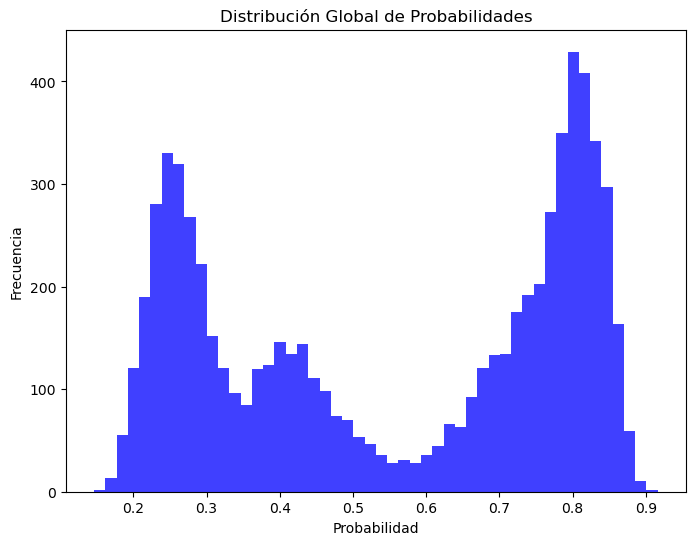

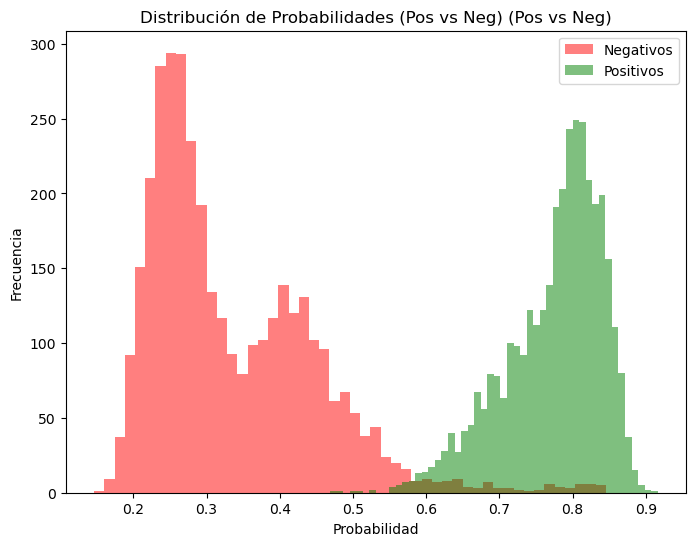

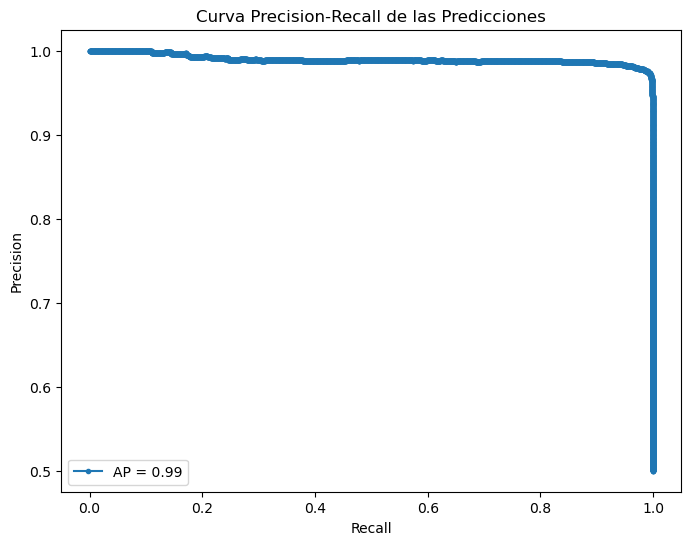

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_probability_distribution(probs, labels=None, title="Distribución de Probabilidades"):
    """
    Grafica un histograma de las probabilidades.
    Si se pasan 'labels' (0 o 1 para cada elemento), se grafican separadamente positivos y negativos.
    """
    plt.figure(figsize=(8, 6))
    if labels is None:
        plt.hist(probs, bins=50, alpha=0.75, color="blue")
        plt.title(title)
        plt.xlabel("Probabilidad")
        plt.ylabel("Frecuencia")
    else:
        probs = np.array(probs).flatten()
        labels = np.array(labels).flatten()
        pos_probs = probs[labels == 1]
        neg_probs = probs[labels == 0]
        plt.hist(neg_probs, bins=50, alpha=0.5, label="Negativos", color="red")
        plt.hist(pos_probs, bins=50, alpha=0.5, label="Positivos", color="green")
        plt.title(title + " (Pos vs Neg)")
        plt.xlabel("Probabilidad")
        plt.ylabel("Frecuencia")
        plt.legend()
    plt.show()

def plot_precision_recall(probs, labels, title="Curva Precision-Recall"):
    """
    Calcula y grafica la curva precision–recall.
    Muestra además el Average Precision (AP) en la leyenda.
    """
    precision, recall, thresholds = precision_recall_curve(labels, probs)
    average_precision = average_precision_score(labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP = {average_precision:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()

# Supongamos que ya tienes definido:
# - un modelo entrenado (model)
# - el conjunto de test (test_data, de tipo HeteroData)
#
# Por ejemplo, en tu entorno ya deberían existir variables como:
# model = <tu modelo cargado>
# test_data = <tu HeteroData de test>

# Realizamos el forward sobre test_data (sin gradientes)
with torch.no_grad():
    pred = model(test_data)  # pred es un tensor de logits para la relación ("Drug", "DrugHasIndication", "Disorder")
    ground_truth = test_data["Drug", "DrugHasIndication", "Disorder"].edge_label

# Convertimos a probabilidades y a arrays de NumPy
probs = torch.sigmoid(pred).detach().cpu().numpy()
labels = ground_truth.detach().cpu().numpy()

# Visualizamos la distribución global de probabilidades
plot_probability_distribution(probs, title="Distribución Global de Probabilidades")

# Visualizamos la distribución separada por positivos y negativos
plot_probability_distribution(probs, labels, title="Distribución de Probabilidades (Pos vs Neg)")

# Graficamos la curva Precision-Recall
plot_precision_recall(probs, labels, title="Curva Precision-Recall de las Predicciones")


In [24]:
import torch
import numpy as np
import pandas as pd

def get_display_name_for_drug_id(drug_id, nodes_csv):
    """
    Dado un drug_id interno, retorna su displayName desde el CSV.
    """
    nodes_df = pd.read_csv(nodes_csv)
    drugs_df = nodes_df[nodes_df['type'] == 'Drug'].reset_index(drop=True)
    # Asumimos que 'drug_id' coincide con el índice interno
    # Si en tu CSV hay una columna 'id' distinta, ajusta la lógica
    if 'id' in drugs_df.columns:
        # Diccionario: id_interno_csv -> displayName
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
        return drug_mapping.get(drug_id, f"Drug_{drug_id}")
    else:
        # Si no hay 'id', asumimos que el índice coincide
        if drug_id < len(drugs_df):
            return drugs_df.iloc[drug_id]['displayName']
        else:
            return f"Drug_{drug_id}"

def get_display_name_for_disorder_id(disorder_id, nodes_csv):
    """
    Dado un disorder_id interno, retorna su displayName desde el CSV.
    """
    nodes_df = pd.read_csv(nodes_csv)
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder'].reset_index(drop=True)
    if 'id' in disorders_df.columns:
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
        return disorder_mapping.get(disorder_id, f"Disorder_{disorder_id}")
    else:
        if disorder_id < len(disorders_df):
            return disorders_df.iloc[disorder_id]['displayName']
        else:
            return f"Disorder_{disorder_id}"

def predict_top_disorders_for_drug_id(
    model,
    data,
    drug_id,
    top_k=5,
    device='cpu',
    nodes_csv='nodes.csv',
    use_sigmoid=True
):
    """
    Dado un 'drug_id', crea temporalmente un edge_label_index con
    todos los disorders y ese drug, ejecuta el forward para obtener
    un score por par (drug, disorder), y retorna los top_k con mayor score.

    Además, muestra el displayName del fármaco consultado y de cada disorder predicho.
    """
    model.eval()
    data = data.to(device)

    # Obtener el displayName del drug consultado
    drug_name = get_display_name_for_drug_id(drug_id, nodes_csv)

    # Leer CSV para mapear IDs internos de Disorder a displayName
    nodes_df = pd.read_csv(nodes_csv)
    disorders_df = nodes_df[nodes_df['type'] == 'Disorder'].reset_index(drop=True)
    if 'id' in disorders_df.columns:
        disorder_mapping = {row['id']: row['displayName'] for _, row in disorders_df.iterrows()}
    else:
        disorder_mapping = {idx: row['displayName'] for idx, row in disorders_df.iterrows()}

    # 1) edge_label_index temporal (2, num_disorders)
    all_disorder_ids = torch.arange(data["Disorder"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        torch.full_like(all_disorder_ids, fill_value=drug_id),  # Fila 0: drug_id repetido
        all_disorder_ids                                       # Fila 1: 0..num_disorders-1
    ], dim=0)

    # 2) Guardar valores originales
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    old_edge_label_index = edge_storage.get('edge_label_index', None)
    old_edge_label = edge_storage.get('edge_label', None)

    try:
        # Asignar temporalmente
        edge_storage['edge_label_index'] = edge_label_index_temp
        edge_storage['edge_label'] = torch.zeros(edge_label_index_temp.size(1), device=device)

        # 3) Forward -> logits
        preds = model(data)

    finally:
        # Restaurar
        if old_edge_label_index is not None:
            edge_storage['edge_label_index'] = old_edge_label_index
        else:
            if 'edge_label_index' in edge_storage:
                del edge_storage['edge_label_index']
        if old_edge_label is not None:
            edge_storage['edge_label'] = old_edge_label
        else:
            if 'edge_label' in edge_storage:
                del edge_storage['edge_label']

    # 4) Interpretar la salida
    if use_sigmoid:
        scores = torch.sigmoid(preds).detach().cpu().numpy()
    else:
        scores = preds.detach().cpu().numpy()

    # 5) Ordenar descendentemente y extraer top_k
    sorted_indices = np.argsort(-scores)
    top_indices = sorted_indices[:top_k]
    top_scores = scores[top_indices]

    # 6) Mapear IDs internos de Disorder a displayName
    top_disorder_names = []
    for idx in top_indices:
        # idx es un índice interno de Disorder en data["Disorder"]
        if idx in disorder_mapping:
            top_disorder_names.append(disorder_mapping[idx])
        else:
            top_disorder_names.append(f"Disorder_{idx}")

    return drug_name, top_disorder_names, top_scores


def predict_top_drugs_for_disorder_id(
    model,
    data,
    disorder_id,
    top_k=5,
    device='cpu',
    nodes_csv='nodes.csv',
    use_sigmoid=True
):
    """
    Dado un 'disorder_id', crea temporalmente un edge_label_index con
    todos los drugs y ese disorder, ejecuta el forward y retorna top_k.

    Además, muestra el displayName del disorder consultado y de cada drug predicho.
    """
    model.eval()
    data = data.to(device)

    # Obtener el displayName del disorder consultado
    disorder_name = get_display_name_for_disorder_id(disorder_id, nodes_csv)

    # CSV para mapear IDs de drugs
    nodes_df = pd.read_csv(nodes_csv)
    drugs_df = nodes_df[nodes_df['type'] == 'Drug'].reset_index(drop=True)
    if 'id' in drugs_df.columns:
        drug_mapping = {row['id']: row['displayName'] for _, row in drugs_df.iterrows()}
    else:
        drug_mapping = {idx: row['displayName'] for idx, row in drugs_df.iterrows()}

    # 1) edge_label_index temporal
    all_drug_ids = torch.arange(data["Drug"].num_nodes, device=device)
    edge_label_index_temp = torch.stack([
        all_drug_ids,  # Fila 0: 0..num_drugs-1
        torch.full_like(all_drug_ids, fill_value=disorder_id)  # Fila 1: disorder_id repetido
    ], dim=0)

    # 2) Guardar
    rel_key = ("Drug", "DrugHasIndication", "Disorder")
    edge_storage = data[rel_key]
    old_edge_label_index = edge_storage.get('edge_label_index', None)
    old_edge_label = edge_storage.get('edge_label', None)

    try:
        # Asignar
        edge_storage['edge_label_index'] = edge_label_index_temp
        edge_storage['edge_label'] = torch.zeros(edge_label_index_temp.size(1), device=device)

        # 3) Forward
        preds = model(data)

    finally:
        # Restaurar
        if old_edge_label_index is not None:
            edge_storage['edge_label_index'] = old_edge_label_index
        else:
            if 'edge_label_index' in edge_storage:
                del edge_storage['edge_label_index']
        if old_edge_label is not None:
            edge_storage['edge_label'] = old_edge_label
        else:
            if 'edge_label' in edge_storage:
                del edge_storage['edge_label']

    # 4) Convertir
    if use_sigmoid:
        scores = torch.sigmoid(preds).detach().cpu().numpy()
    else:
        scores = preds.detach().cpu().numpy()

    # 5) Ordenar y extraer top_k
    sorted_indices = np.argsort(-scores)
    top_indices = sorted_indices[:top_k]
    top_scores = scores[top_indices]

    # 6) Mapear drug_id interno a displayName
    top_drug_names = []
    for idx in top_indices:
        if idx in drug_mapping:
            top_drug_names.append(drug_mapping[idx])
        else:
            top_drug_names.append(f"Drug_{idx}")

    return disorder_name, top_drug_names, top_scores


In [25]:
model.load_state_dict(torch.load("gnn_model_ranking.pth", map_location='cpu'))
model.eval()


Model(
  (disorder_lin): Linear(in_features=768, out_features=768, bias=True)
  (drug_lin): Linear(in_features=768, out_features=768, bias=True)
  (protein_lin): Linear(in_features=768, out_features=768, bias=True)
  (gene_lin): Linear(in_features=768, out_features=768, bias=True)
  (gnn): GNN(
    (convs): ModuleList(
      (0-2): 3 x SAGEConv(768, 768, aggr=mean)
    )
    (bns): ModuleList(
      (0-1): 2 x BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (classifier): ClassifierMLP(
    (fc1): Linear(in_features=1536, out_features=768, bias=True)
    (fc2): Linear(in_features=768, out_features=1, bias=True)
  )
  (hetero_gnn): GraphModule(
    (convs): ModuleList(
      (0-2): 3 x ModuleDict(
        (Gene__GeneAssociatedWithDisorder__Disorder): SAGEConv(768, 768, aggr=mean)
        (Disorder__DisorderIsSubtypeOfDisorder__Disorder): SAGEConv(768, 768, aggr=mean)
        (Protein__ProteinEncodedByGene__Gene): SAGEConv(768, 768, aggr=mean)


In [26]:
drug_id = 42
drug_name, top_disorders, top_scores = predict_top_disorders_for_drug_id(
    model, data, drug_id, top_k=5, device='cpu', nodes_csv='nodes.csv', use_sigmoid=True
)
print(f"Top {len(top_disorders)} disorders para el fármaco '{drug_name}':")
for name, score in zip(top_disorders, top_scores):
    print(f"  - {name:<40} Score: {score:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_13760\67609146.py:9: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)
C:\Users\gema\AppData\Local\Temp\ipykernel_13760\67609146.py:62: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)


Top 5 disorders para el fármaco 'Collagenase clostridium histolyticum':
  - perennial allergic rhinitis              Score: 0.7655
  - nicotine dependence                      Score: 0.7632
  - opiate dependence                        Score: 0.7602
  - allergic rhinitis                        Score: 0.7583
  - retinitis                                Score: 0.7500


In [27]:
disorder_id = 123
disorder_name, top_drugs, top_scores = predict_top_drugs_for_disorder_id(
    model, data, disorder_id, top_k=5, device='cpu', nodes_csv='nodes.csv', use_sigmoid=True
)
print(f"Top {len(top_drugs)} drugs para el disorder '{disorder_name}':")
for name, score in zip(top_drugs, top_scores):
    print(f"  - {name:<40} Score: {score:.4f}")


C:\Users\gema\AppData\Local\Temp\ipykernel_13760\67609146.py:28: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)
C:\Users\gema\AppData\Local\Temp\ipykernel_13760\67609146.py:148: DtypeWarning: Columns (0,1,2,3,8,9,10,11,13,14,15,16,17,18,22,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_df = pd.read_csv(nodes_csv)


Top 5 drugs para el disorder 'brain ischemia':
  - Guaifenesin                              Score: 0.8424
  - Lofexidine                               Score: 0.8419
  - Buprenorphine                            Score: 0.8414
  - Fesoterodine                             Score: 0.8405
  - Chlorphentermine                         Score: 0.8398


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_data_distribution(
    data,
    rel_key=("Drug", "DrugHasIndication", "Disorder"),
    device='cpu',
    plot_histograms=True
):
    """
    Explora la distribución de datos en la relación 'rel_key'.
    Asume que data[rel_key].edge_index (2, num_edges) y data[rel_key].edge_label (num_edges) existen.
    
    1) Imprime resumen global (#positivos, #negativos, proporción).
    2) Calcula para cada fármaco cuántos enlaces positivos tiene (degree positivo).
    3) Calcula para cada disorder cuántos enlaces positivos tiene.
    4) (Opcional) Grafica histogramas de dichas distribuciones.
    """
    data = data.to(device)
    edge_index = data[rel_key].edge_index  # [2, num_edges]
    edge_label = data[rel_key].edge_label  # [num_edges]

    num_edges = edge_index.size(1)
    labels = edge_label.detach().cpu().numpy()
    positives = (labels == 1).sum()
    negatives = (labels == 0).sum()

    print(f"=== Análisis de la relación {rel_key} ===")
    print(f"Total de aristas (pos+neg): {num_edges}")
    print(f"Positivos: {positives} | Negativos: {negatives}")
    print(f"Proporción de positivos: {positives/num_edges:.4f}")

    ei = data[("Drug","DrugHasIndication","Disorder")].edge_index
    el = data[("Drug","DrugHasIndication","Disorder")].edge_label
    print("edge_index shape:", ei.shape)       # Debe ser (2, num_edges)
    print("edge_label shape:", el.shape)       # Debe ser (num_edges, )


    # edge_index[0] -> drug_ids
    # edge_index[1] -> disorder_ids
    drug_ids = edge_index[0].cpu().numpy()
    disorder_ids = edge_index[1].cpu().numpy()

    # Filtramos para quedarnos con los positivos
    pos_mask = (labels == 1)
    pos_drug_ids = drug_ids[pos_mask]
    pos_disorder_ids = disorder_ids[pos_mask]

    # 1) Distribución de positivos por fármaco
    num_drugs = data["Drug"].num_nodes
    drug_positive_counts = np.zeros(num_drugs, dtype=int)
    for d in pos_drug_ids:
        drug_positive_counts[d] += 1

    # 2) Distribución de positivos por disorder
    num_disorders = data["Disorder"].num_nodes
    disorder_positive_counts = np.zeros(num_disorders, dtype=int)
    for ds in pos_disorder_ids:
        disorder_positive_counts[ds] += 1

    # Estadísticas básicas
    print("\n--- Distribución de positivos por fármaco ---")
    print(f"Min: {drug_positive_counts.min()} | Max: {drug_positive_counts.max()} | "
          f"Promedio: {drug_positive_counts.mean():.2f}")

    # Cuántos fármacos tienen 0 positivos, 1 positivo, etc.
    # (Puede ser útil para ver cuántos drugs no tienen indicaciones confirmadas en el dataset)
    unique, counts = np.unique(drug_positive_counts, return_counts=True)
    dist_str = ", ".join([f"{u}:{c}" for u,c in zip(unique, counts)])
    print(f"Conteo (positivos -> #fármacos): {dist_str}")

    print("\n--- Distribución de positivos por disorder ---")
    print(f"Min: {disorder_positive_counts.min()} | Max: {disorder_positive_counts.max()} | "
          f"Promedio: {disorder_positive_counts.mean():.2f}")

    unique2, counts2 = np.unique(disorder_positive_counts, return_counts=True)
    dist_str2 = ", ".join([f"{u}:{c}" for u,c in zip(unique2, counts2)])
    print(f"Conteo (positivos -> #disorders): {dist_str2}")

    # 3) (Opcional) Visualizar histogramas
    if plot_histograms:
        # Hist de #positivos por fármaco
        plt.figure(figsize=(6,4))
        plt.hist(drug_positive_counts, bins=50, alpha=0.7, color='blue')
        plt.title("Distribución de #positivos por fármaco")
        plt.xlabel("#positivos (DrugHasIndication)")
        plt.ylabel("Frecuencia")
        plt.show()

        # Hist de #positivos por disorder
        plt.figure(figsize=(6,4))
        plt.hist(disorder_positive_counts, bins=50, alpha=0.7, color='green')
        plt.title("Distribución de #positivos por disorder")
        plt.xlabel("#positivos (DrugHasIndication)")
        plt.ylabel("Frecuencia")
        plt.show()

    print("\n=== Fin del análisis de distribución ===")


In [32]:
analyze_data_distribution(train_data, rel_key=("Drug","DrugHasIndication","Disorder"), device='cpu')


=== Análisis de la relación ('Drug', 'DrugHasIndication', 'Disorder') ===
Total de aristas (pos+neg): 12409
Positivos: 12409 | Negativos: 2481
Proporción de positivos: 1.0000
edge_index shape: torch.Size([2, 12409])
edge_label shape: torch.Size([14890])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 12409 but corresponding boolean dimension is 14890